
## ▣ 따릉이 대여소별 대여량 반납량 예측을 통한 반납 대여소 서비스 : 여기 따릉이 대 (여따대)


### ※ 본격적인 대여량, 반납량 예측 모형을 만들기 앞서서 대략적인 대여, 반납 추이를 보기 위한 데이터분석

#### 1. 대여반납 추이 알아보기 (함수 Create_Bike_Plot(bike_df,name) 사용)
- 이용한 데이터 : 한달 대여, 반납량 데이터(매달 바꿔서 할 수 있음)
- 분석 결과 : 시간별(0시-23시) 대여량, 반납량, 대여-반납 그래프
- 분석 목적 : 시간별로 대여, 반납량이 어떻게 다른지 알기 위해 그래프를 그려봄
- 추후 특정 대여소를 기반으로 대여, 반납량 예측모형을 만들 때 시간별 대여 반납 그래프를 통해 예측이 필요한 지 판단가능함

#### 2. 추가배치 요청건수 데이터
1) (대여소 구분없이)일별 추가배치 요청건수 데이터

2) 대여소별 추가배치요청건수 데이터

3) 신청합계가 많은 날짜의 추가요청건수가 많은 대여소는 어디일까

4) 추가배치 요청건수 합계 top500

#### 3. 대여량, 반납량이 많은 대여소 찾기 
- 이용한 데이터 : 공공자전거 대여소별 이용정보 17년부터 21년까지 월별 대여, 반납 내역

1) 대여량 높은 대여소 알아보기
- 대여량 합계 top500, 월별 대여량 평균 top500

2) 반납량 높은 대여소
- 반납량 합계 top500, 월별 반납량 평균 top500

3) 대여량도 높고 반납량도 높은 대여소 알아보기
- 대여소를 대여, 반납량에 따라 분류하기


In [1]:
#필요한 함수 모음
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #그래프
plt.rcParams['font.family'] = 'NanumGothic' #그래프의 한글깨짐 현상 해결
plt.rc('axes',unicode_minus=False)
from pandas import DataFrame  # 데이터프레임 클래스
from pandas import Series     # 시리즈 클래스
from pandas import ExcelFile  # Excel 파일을 읽어들이기 위한 클래스
from pandas import concat     # 행단위 병합기능을 제공하는 함수
from pandas import merge
from datetime import datetime

#### 1. 대여반납 추이 알아보기 (함수 Create_Bike_Plot(bike_df,name) 사용)
- Data load (대여반납이 활발한 6월데이터 사용)

In [2]:
bike_1 = pd.read_csv('공공자전거 대여이력 정보_2020.06.csv',encoding='cp949')
bike_1

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-33273,2020-06-01 00:03:05,1050,둔촌역 3번 출입구,0,2020-06-01 00:05:59,1078,둔촌사거리,0,3,0.00
1,SPB-30703,2020-06-01 00:00:46,1132,등촌역 7번출구,0,2020-06-01 00:06:53,1169,염창역 1번 출구,0,6,0.00
2,SPB-31969,2020-06-01 00:02:43,1306,한성대입구역2번출구,0,2020-06-01 00:06:59,388,동성중학교 앞,0,4,0.00
3,SPB-19763,2020-06-01 00:00:16,956,응암시장교차로,8,2020-06-01 00:08:25,939,은평구청 교차로,6,7,1340.00
4,SPB-32949,2020-06-01 00:04:20,709,신정3동 현장민원실 앞,0,2020-06-01 00:08:53,712,강월초교입구 사거리,0,5,0.00
...,...,...,...,...,...,...,...,...,...,...,...
1755041,SPB-14356,2020-06-30 23:55:00,1160,양천향교역 7번출구앞,2,2020-07-01 01:55:02,1160,양천향교역 7번출구앞,1,119,18060.00
1755042,SPB-14454,2020-06-30 18:55:01,1235,잠실트리지움310동 옆,3,2020-07-01 02:46:48,1221,삼전사거리 포스코더샵,4,471,870.00
1755043,SPB-12680,2020-06-30 13:01:33,1346,길음8골어린이공원 옆,1,2020-07-01 02:50:27,1347,길음래미안아파트817동 상가 앞,1,15,7230.00
1755044,SPB-32402,2020-06-30 16:45:32,1956,도야미리숯불갈비 앞,0,2020-07-01 08:04:52,1956,도야미리숯불갈비 앞,0,919,39786.76


- 대여반납 그래프 함수

In [3]:
def Create_Bike_Plot(bike_df, name) :
    month_index = ['0' + str(i) for i in range(10)] + [str(i) for i in range(10, 24)]
    
    대여 = bike_df[bike_df['대여 대여소명'] == name].iloc[:, [1,3]]
    대여['대여일시'] = [date.split('-')[-1].split(' ')[-1].split(':')[0] for date in 대여.대여일시]
    대여 = 대여.groupby('대여일시').count()
    for month in month_index :
        if not(month in 대여.index) :
            대여.loc[month] = [0]
    대여 = 대여.sort_index()
    
    반납 = bike_df[bike_df['반납대여소명'] == name].iloc[:, [5, 7]]
    반납['반납일시'] = [date.split('-')[-1].split(' ')[-1].split(':')[0] for date in 반납.반납일시]
    반납 = 반납.groupby('반납일시').count()
    for month in month_index :
        if not(month in 반납.index) :
            반납.loc[month] = [0]
    반납 = 반납.sort_index()
    
    fig, ax = plt.subplots(1, 2, figsize = (25, 8))
    
    ax[0].plot(대여, c = 'r', label = '대여 수')
    ax[0].plot(반납, c = 'b', label = '반납 수')
    ax[0].legend()
    ax[1].plot(대여['대여 대여소명'] - 반납['반납대여소명'], c = 'crimson', label = '대여 수 - 반납 수')
    ax[1].legend()
    ax[1].axhline(0, 0, 1, c = 'gray')

- 그래프 그리기

1) 한강공원 근처

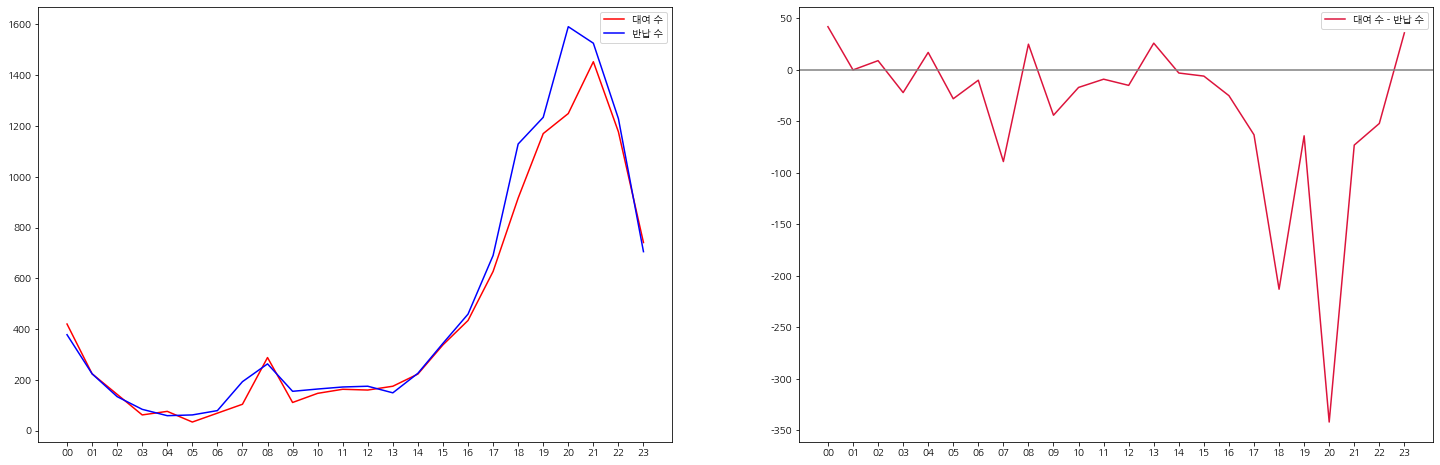

In [4]:
Create_Bike_Plot(bike_1,'뚝섬유원지역 1번출구 앞')

2) 역 주변

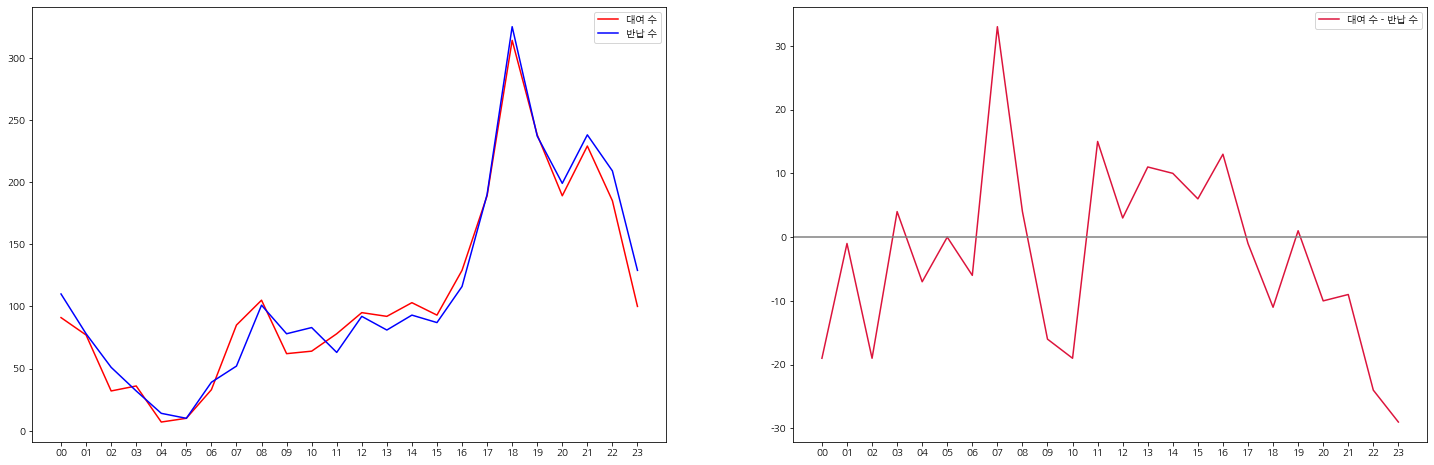

In [5]:
Create_Bike_Plot(bike_1,'공덕역 8번출구')

3) 직장 주변

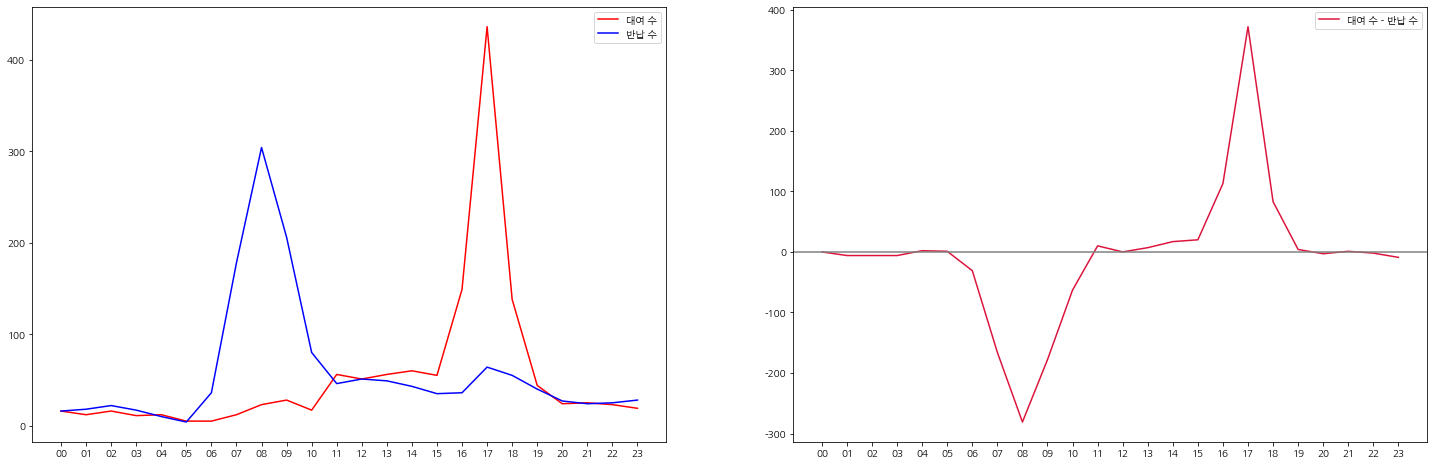

In [6]:
Create_Bike_Plot(bike_1,'포스코사거리(기업은행)')

4) 주거 + 직장 주변

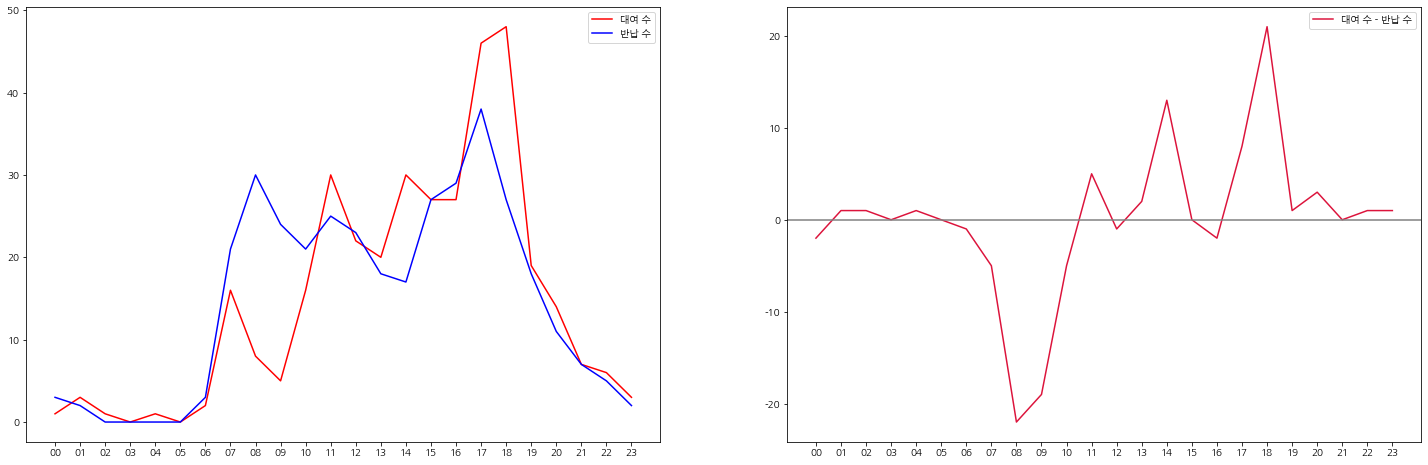

In [7]:
Create_Bike_Plot(bike_1,'명동성당 앞')

5) 공원 근처

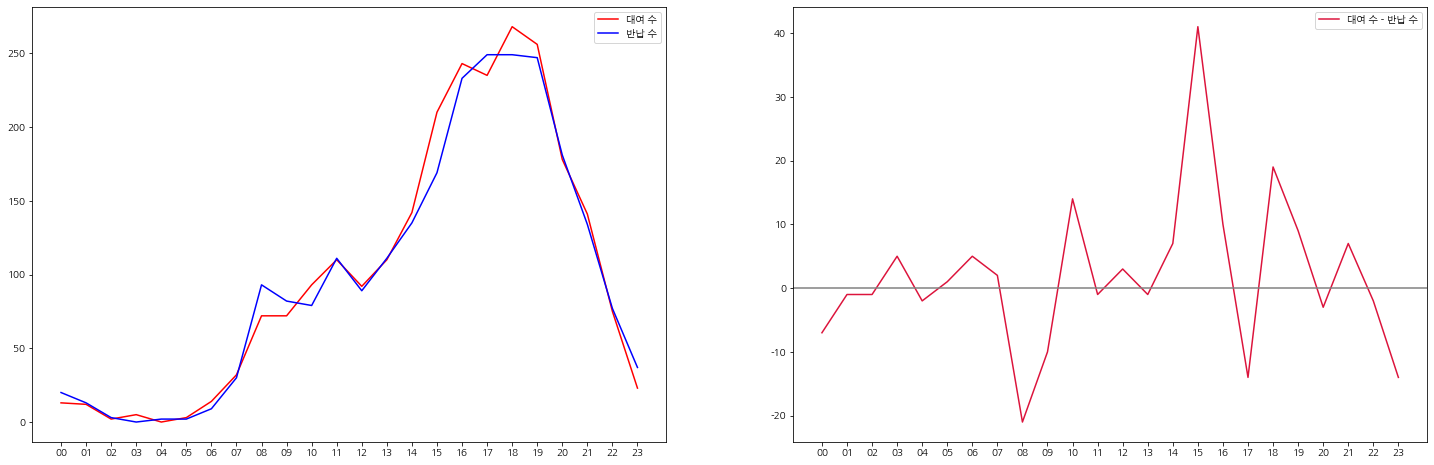

In [8]:
Create_Bike_Plot(bike_1,'서울숲 관리사무소')

#### 2. 추가배치 요청건수 데이터
1) (대여소 구분없이)일별 추가배치 요청건수 데이터

In [9]:
#추가배치요청건수 대여소 구분 없이 일별 총합
add_request_day = pd.read_csv('정보공개답변서일별.csv',encoding='UTF-8',header=0)
add_request_day = add_request_day.iloc[0:220,:]
add_request_day

,행 레이블,합계 : 신청합계
0,2021-01-01,69
1,2021-01-02,58
2,2021-01-03,66
3,2021-01-04,271
4,2021-01-05,244
...,...,...
215,2021-08-04,1702
216,2021-08-05,1603
217,2021-08-06,1482
218,2021-08-07,823


<AxesSubplot:>

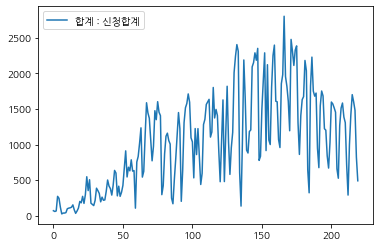

In [10]:
add_request_day.plot()

In [11]:
#총합계를 제외 하고 최대 요청된 날짜 확인
add_request_day[add_request_day['합계 : 신청합계'] == max(add_request_day['합계 : 신청합계'])]

,행 레이블,합계 : 신청합계
166,2021-06-16,2805


2) 대여소별 추가배치요청건수 데이터

In [12]:
add_request = pd.read_csv('정보공개답변서.csv',encoding='UTF-8',header=0)
add_request = add_request.iloc[:,0:3]
add_request.대여소명 = [place.split('. ')[-1] for place in add_request.대여소명]
add_request.대여소명 = [place.split('.')[-1] for place in add_request.대여소명]
add_request

,요청일자,대여소명,신청합계
0,2021-01-01,방화사거리 마을버스 버스정류장,1
1,2021-01-01,방화근린공원,1
2,2021-01-01,우장산역 1번출구옆(우장산아이파크105동앞),3
3,2021-01-01,강서구립등빛도서관,1
4,2021-01-01,거여역 3번출구,2
...,...,...,...
115355,2021-08-08,독바위역,1
115356,2021-08-08,서울연신중학교,2
115357,2021-08-08,서울특별시 은평병원,1
115358,2021-08-08,원풍빌라앞,2


In [13]:
#대여소별 요청건수 합계
add_request.groupby(add_request['대여소명'],as_index=False).sum()

,대여소명,신청합계
0,강동구청 앞,45
1,둔촌역 3번 출입구,31
2,(구)신한은행 중랑교지점,9
3,(구)합정동 주민센터,1
4,(시립)고덕평생학습관,83
...,...,...
2429,흑석한강푸르지오(110동),43
2430,흥국사 정류장,1
2431,희성오피앙,37
2432,희훈타워빌 앞,21


<AxesSubplot:>

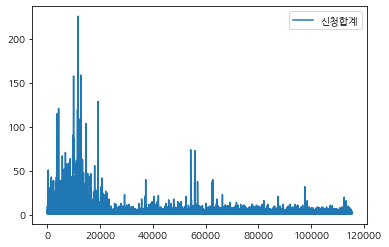

In [14]:
add_request.plot()

In [15]:
add_request['신청합계'].mean()

1.984353328710125

- 신청합계의 평균은 2인데 신청합계의 그래프를 보니 이상값들이 많다고 생각되어짐

In [16]:
add_request.describe()

,신청합계
count,115360.000000
mean,1.984353
std,2.427365
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,226.000000


- add_request 데이터를 살펴보니 하루 신청합계 평균은 약 2회, 하위 75%까지 2이지만 최대 신청합계가 226이므로 데이터 정제가 필요하다고 생각했다.  

In [17]:
add_requestnew = add_request[add_request['신청합계'] < 4]
add_requestnew

,요청일자,대여소명,신청합계
0,2021-01-01,방화사거리 마을버스 버스정류장,1
1,2021-01-01,방화근린공원,1
2,2021-01-01,우장산역 1번출구옆(우장산아이파크105동앞),3
3,2021-01-01,강서구립등빛도서관,1
4,2021-01-01,거여역 3번출구,2
...,...,...,...
115355,2021-08-08,독바위역,1
115356,2021-08-08,서울연신중학교,2
115357,2021-08-08,서울특별시 은평병원,1
115358,2021-08-08,원풍빌라앞,2


3) 신청합계가 많은 날짜의 추가요청건수가 많은 대여소는 어디일까

In [18]:
add_date= add_requestnew.groupby(add_requestnew['요청일자'],as_index=False).sum()
add_date.sort_values(by='신청합계',ascending = False).iloc[:500,:]

,요청일자,신청합계
171,2021-06-21,1649
166,2021-06-16,1581
172,2021-06-22,1562
181,2021-07-01,1541
133,2021-05-14,1538
...,...,...
7,2021-01-08,36
16,2021-01-17,32
9,2021-01-10,25
8,2021-01-09,16


In [19]:
add_topdate = add_requestnew[add_requestnew['요청일자'] =='2021-06-21']
add_topdate_bike = add_topdate.groupby(add_topdate['대여소명'],as_index=False).sum()
add_topdate_bike[add_topdate_bike['신청합계']==3].to_csv('추가요청건수가 가장 많은날의 대여소 들 중 신청합계가 높은 대여소.csv',encoding='cp949')
add_topdate_bike[add_topdate_bike['신청합계']==3]

,대여소명,신청합계
1,19탑 앞,3
13,JK장평타워,3
15,JW타워,3
16,K+ 타워 앞,3
27,LG한강 자이아파트 앞,3
...,...,...
944,현대시장사거리(신한은행),3
945,현대아파트 정문 앞,3
949,홍대입구역 6번출구,3
950,홍대입구역 8번출구 앞,3


- 신청합계의 총합 대여소명으로 groupby

In [20]:
add_sum = add_requestnew.groupby(add_requestnew['대여소명'],as_index=False).sum()
add_sum

,대여소명,신청합계
0,강동구청 앞,45
1,둔촌역 3번 출입구,31
2,(구)신한은행 중랑교지점,9
3,(구)합정동 주민센터,1
4,(시립)고덕평생학습관,75
...,...,...
2429,흑석한강푸르지오(110동),43
2430,흥국사 정류장,1
2431,희성오피앙,28
2432,희훈타워빌 앞,21


In [21]:
add_mean = add_requestnew.groupby(add_requestnew['대여소명'],as_index=False).mean()
add_mean_top = add_mean.sort_values(by='신청합계', ascending=False).iloc[:500,:]
add_mean_top

,대여소명,신청합계
1561,신자초교입구 교차로,2.500000
145,강남파이낸스센터앞(역삼역2번출구),2.288136
1458,숭실대학교(중문),2.142857
142,강남구청역 2번출구 뒤,2.115942
1622,압구정로데오역 6번출구,2.097222
...,...,...
1069,사평역 2번출구,1.596774
2374,홍대입구역 2번출구 앞,1.596774
418,금호 어울림 아파트 앞,1.596491
1917,을지로4가역 1번출구,1.596491


4) 추가배치 요청건수 합계 top500
- 추가배치요청건수 합계 제일 높은 대여소명 데이터

In [22]:
add_sum_top = add_sum.sort_values(by='신청합계', ascending=False).iloc[:500,:]
add_sum_top.to_csv('추가건수 신청합계_top500.csv',encoding = 'cp949')
add_sum_top

,대여소명,신청합계
2317,한양수자인아파트 앞,261
1164,상왕십리역 1번출구,234
143,강남세브란스교차로 래미안그레이튼 104동 앞,229
908,문정 법조단지9,227
1846,원묵고등학교,217
...,...,...
794,마장동 금호어울림APT앞,110
1360,성북쉼터 앞,110
1595,쌍용아파트2단지 정문,110
1592,쌍문현대1차아파트 108동 앞,110


In [23]:
add_mean_sum = pd.merge(add_sum_top,add_mean_top,on='대여소명',how='inner')
add_mean_sum.to_csv("add_mean_sum.csv",encoding='cp949')

PermissionError: [Errno 13] Permission denied: 'add_mean_sum.csv'

#### 3. 대여량, 반납량이 많은 대여소 찾기
- 이용한 데이터 : 공공자전거 대여소별 이용정보 17년부터 21년까지 월별 대여, 반납 내역
- 대여 반납 내역이 모두 있는 날짜는 17년 01월부터 20년 06월까지로 그 기간동안의 내역으로만 데이터처리함.
- 합계로 안하고 월 평균으로 한 이유 : 대여소가 계속 새로 생겨 나기 때문에 평균으로 해서 객관성을 높임.

1) 대여량 높은 대여소
- 대여량 월별 대여량 월 평균 top500

2) 반납량 높은 대여소
- 반납량 월별 반납량 월 평균 top500

3) 대여량도 높고 반납량도 높은 대여소 알아보기
- 대여소를 대여, 반납량에 따라 분류하기

1) 대여량 높은 대여소 알아보기

In [24]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["lines.linewidth"] = 3
plt.rc('font', size=13) 
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=13) 

- 통일성을 위한 전처리 함수

In [25]:
def data_pretreatment_rent(df) :
    df.dropna(axis = 0, how = 'any', inplace=True)
    df = df.astype({'지역구' : 'str', '대여소명' : 'str', '대여일자' : int, '대여건수' : int})
    df.대여소명 = [place.split('. ')[-1] for place in df.대여소명]
    df.대여소명 = [place.split('.')[-1] for place in df.대여소명]
    return df

In [26]:
bike_rent_2006 = pd.read_csv('공공자전거 대여소별 이용정보_202006_대여.csv')
bike_rent_2006.columns = ['지역구', '대여소명', '대여일자', '대여건수']
bike_rent_2006 = data_pretreatment_rent(bike_rent_2006)
bike_rent_2006

,지역구,대여소명,대여일자,대여건수
0,강남구,현대고등학교 건너편,202006,4512
1,강남구,교보타워 버스정류장(신논현역 3번출구 후면),202006,1650
2,강남구,논현역 7번출구,202006,1134
3,강남구,신영 ROYAL PALACE 앞,202006,399
4,강남구,MCM 본사 직영점 앞,202006,490
...,...,...,...,...
2057,중랑구,중랑역 1번 출구(중화문화복지센터),202006,85
2058,중랑구,면목삼익아파트 앞,202006,85
2059,중랑구,홈플러스 상봉점 앞,202006,322
2060,중랑구,면목 홈플러스 2,202006,150


In [27]:
bike_rent_2005 = pd.read_csv('공공자전거 대여소별 이용정보_201912_202005_대여.csv')
bike_rent_2005.columns = ['지역구', '대여소명', '대여일자', '대여건수']
bike_rent_2005 = data_pretreatment_rent(bike_rent_2005)
bike_rent_2005

,지역구,대여소명,대여일자,대여건수
0,강남구,현대고등학교 건너편,201912,501
1,강남구,교보타워 버스정류장(신논현역 3번출구 후면),201912,737
2,강남구,논현역 7번출구,201912,460
3,강남구,신영 ROYAL PALACE 앞,201912,150
4,강남구,MCM 본사 직영점 앞,201912,257
...,...,...,...,...
9998,중랑구,상봉역 2번 출구,202005,1802
9999,중랑구,상아빌딩(우림시장 교차로),202005,1113
10000,중랑구,동원사거리,202005,883
10001,중랑구,상봉터미널2,202005,2128


In [28]:
bike_rent_1911 = pd.read_csv('공공자전거 대여소별 이용정보_201906_201911_대여.csv')
bike_rent_1911.columns = ['지역구', '대여소명', '대여일자', '대여건수']
bike_rent_1911 = data_pretreatment_rent(bike_rent_1911)
bike_rent_1911

,지역구,대여소명,대여일자,대여건수
0,강남구,현대고등학교 건너편,201906,3909
1,강남구,교보타워 버스정류장(신논현역 3번출구 후면),201906,2432
2,강남구,논현역 7번출구,201906,1567
3,강남구,신영 ROYAL PALACE 앞,201906,559
4,강남구,MCM 본사 직영점 앞,201906,730
...,...,...,...,...
9267,중랑구,상봉역 2번 출구,201911,1205
9268,중랑구,상아빌딩(우림시장 교차로),201911,764
9269,중랑구,동원사거리,201911,577
9270,중랑구,상봉터미널2,201911,1243


In [29]:
bike_rent_1905 = pd.read_csv('공공자전거 대여소별 이용정보_201812_201905_대여.csv')
bike_rent_1905.columns = ['지역구', '대여소명', '대여일자', '대여건수']
bike_rent_1905 = data_pretreatment_rent(bike_rent_1905)
bike_rent_1905

,지역구,대여소명,대여일자,대여건수
0,강남구,현대고등학교 건너편,201812,364
1,강남구,교보타워 버스정류장(신논현역 3번출구 후면),201812,500
2,강남구,논현역 7번출구,201812,286
3,강남구,신영 ROYAL PALACE 앞,201812,149
4,강남구,MCM 본사 직영점 앞,201812,145
...,...,...,...,...
9184,중랑구,상봉역 2번 출구,201905,1362
9185,중랑구,상아빌딩(우림시장 교차로),201905,826
9186,중랑구,동원사거리,201905,827
9187,중랑구,상봉터미널2,201905,1421


In [30]:
bike_rent_1811 = pd.read_csv('대여소별 대여정보_201807_11.csv',encoding='UTF-8')
bike_rent_1811.dropna(axis = 0, how = 'any', inplace=True)
bike_rent_1811.대여소명 = [place.split('. ')[-1] for place in bike_rent_1811.대여소명]
bike_rent_1811.대여소명 = [place.split('.')[-1] for place in bike_rent_1811.대여소명]
bike_rent_1811

,대여일자,대여소번호,대여소명,대여건수,반납건수
0,201806,101,(구)합정동 주민센터,832,807
1,201806,102,망원역 1번출구 앞,2819,2568
2,201806,103,망원역 2번출구 앞,1977,1769
3,201806,104,합정역 1번출구 앞,1682,1610
4,201806,105,합정역 5번출구 앞,1105,925
...,...,...,...,...,...
8033,201811,3534,건대입구역 5번출구 뒤,1278,1277
8034,201811,3535,중곡사거리(국민은행),459,519
8035,201811,3536,중앙농협(자양동),545,535
8036,201811,3537,아차산 휴먼시아 아파트 옆,267,204


In [31]:
bike_rent_1806 = pd.read_csv('서울특별시 공공자전거 대여소별 이용정보(월간)_2018_1_6.csv', encoding='euc-kr')
bike_rent_1806 = bike_rent_1806.rename(columns={'대여소':'대여소명'})
bike_rent_1806.dropna(axis = 0, how = 'any', inplace=True)
bike_rent_1806

,대여일자,대여소번호,대여소명,대여건수,반납건수
0,201801,108,서교동 사거리,355,422
1,201801,503,더샵스타시티 C동 앞,287,256
2,201801,731,서울시 도로환경관리센터,0,4
3,201801,504,신자초교입구교차로,370,368
4,201801,740,으뜸공원,0,1
...,...,...,...,...,...
7007,201806,722,LG전자베스트샵 신정점,875,1003
7008,201806,723,SBS방송국,1441,1610
7009,201806,724,계남공원 입구 주출입구 좌측,204,199
7010,201806,725,양강중학교앞 교차로,435,178


In [32]:
bike_rent_1712 = pd.read_csv('서울특별시 공공자전거 대여소별 이용정보(월간)_2017_1_12.csv', encoding='euc-kr')
bike_rent_1712 = bike_rent_1712.rename(columns={'대여소':'대여소명'})
bike_rent_1712.dropna(axis = 0, how = 'any', inplace=True)
bike_rent_1712

,대여일자,대여소번호,대여소명,대여건수,반납건수
0,201701,108,서교동 사거리,246,198
1,201701,503,더샵스타시티 C동 앞,246,224
2,201701,504,신자초교입구교차로,232,261
3,201701,505,자양사거리 광진아크로텔 앞,302,313
4,201701,506,금호 어울림 아파트 앞,72,77
...,...,...,...,...,...
8557,201712,3503,광진유진스웰,33,21
8558,201712,3504,원일교회,196,159
8559,201712,3505,신양초교앞 교차로,124,106
8560,201712,502,뚝섬유원지역 1번출구 앞,571,719


- 데이터 합치기

In [33]:
bike_rent_1701_1811 = pd.concat([bike_rent_1712, bike_rent_1806, bike_rent_1811])
bike_rent_1701_1811 = bike_rent_1701_1811[['대여소명', '대여일자', '대여건수']]
bike_rent_1701_1811

,대여소명,대여일자,대여건수
0,서교동 사거리,201701,246
1,더샵스타시티 C동 앞,201701,246
2,신자초교입구교차로,201701,232
3,자양사거리 광진아크로텔 앞,201701,302
4,금호 어울림 아파트 앞,201701,72
...,...,...,...
8033,건대입구역 5번출구 뒤,201811,1278
8034,중곡사거리(국민은행),201811,459
8035,중앙농협(자양동),201811,545
8036,아차산 휴먼시아 아파트 옆,201811,267


In [34]:
bike_rent_1812_2006 = pd.concat([bike_rent_1905, bike_rent_1911, bike_rent_2005, bike_rent_2006])
bike_rent_1812_2006.drop('지역구', axis = 1, inplace = True)
bike_rent_1812_2006

,대여소명,대여일자,대여건수
0,현대고등학교 건너편,201812,364
1,교보타워 버스정류장(신논현역 3번출구 후면),201812,500
2,논현역 7번출구,201812,286
3,신영 ROYAL PALACE 앞,201812,149
4,MCM 본사 직영점 앞,201812,145
...,...,...,...
2057,중랑역 1번 출구(중화문화복지센터),202006,85
2058,면목삼익아파트 앞,202006,85
2059,홈플러스 상봉점 앞,202006,322
2060,면목 홈플러스 2,202006,150


In [35]:
bike_rent_1701_2006 = pd.concat([bike_rent_1701_1811,bike_rent_1812_2006])
bike_rent_1701_2006

,대여소명,대여일자,대여건수
0,서교동 사거리,201701,246
1,더샵스타시티 C동 앞,201701,246
2,신자초교입구교차로,201701,232
3,자양사거리 광진아크로텔 앞,201701,302
4,금호 어울림 아파트 앞,201701,72
...,...,...,...
2057,중랑역 1번 출구(중화문화복지센터),202006,85
2058,면목삼익아파트 앞,202006,85
2059,홈플러스 상봉점 앞,202006,322
2060,면목 홈플러스 2,202006,150


- 대여량 평균 top 500 대여소

In [36]:
bike_rent_mean = bike_rent_1701_2006.groupby('대여소명',as_index=False).mean() # 대여소별로 기간별 평균구함
bike_rent_mean = bike_rent_mean.astype({'대여건수' : int})
bike_rent_mean.drop('대여일자', axis = 1, inplace = True)
bike_rent_mean_top500 = bike_rent_mean.sort_values(by = '대여건수', ascending=False).iloc[:500, :] # 평균 top500선정
bike_rent_mean_top500.columns = ['대여소명','월 평균 대여건수']

In [37]:
bike_rent_mean

,대여소명,대여건수
0,강동구청 앞,273
1,둔촌역 3번 출입구,1173
2,(구)신한은행 중랑교지점,231
3,(구)합정동 주민센터,380
4,3호선 매봉역 3번출구앞,452
...,...,...
3447,흑석한강푸르지오 106동앞,202
3448,흑석한강푸르지오(110동),103
3449,흥국사 정류장,17
3450,희성오피앙,609


In [38]:
bike_rent_mean_top500

,대여소명,월 평균 대여건수
2781,여의나루역 1번출구 앞,8883
1895,뚝섬유원지역 1번출구 앞,8821
2173,봉림교 교통섬,5654
3404,홍대입구역 2번출구 앞,5606
1485,"고속터미널역 8-1번, 8-2번 출구 사이",5493
...,...,...
1059,종각역 1번출구 앞,1204
1478,고덕역 4번출구,1203
1732,답십리초등학교 앞(현대시장 옆),1201
1762,대방역 4번출구,1201


2) 반납량 높은 대여소 알아보기

- 통일성을 위한 전처리 함수 (방식은 대여량과 똑같음)

In [39]:
def data_pretreatment_return(df) :
    df.dropna(axis = 0, how = 'any', inplace=True)
    df = df.astype({'지역구' : 'str', '대여소명' : 'str', '반납일자' : int, '반납건수' : int})
    df.대여소명 = [place.split('. ')[-1] for place in df.대여소명]
    df.대여소명 = [place.split('.')[-1] for place in df.대여소명]
    return df

In [40]:
bike_return_2006 = pd.read_csv('공공자전거 대여소별 이용정보_202006_반납.csv')
bike_return_2006.columns = ['지역구', '대여소명', '반납일자', '반납건수']
bike_return_2006 = data_pretreatment_return(bike_return_2006)
bike_return_2006

,지역구,대여소명,반납일자,반납건수
0,강남구,현대고등학교 건너편,202006,4714
1,강남구,교보타워 버스정류장(신논현역 3번출구 후면),202006,1628
2,강남구,논현역 7번출구,202006,1072
3,강남구,신영 ROYAL PALACE 앞,202006,130
4,강남구,MCM 본사 직영점 앞,202006,475
...,...,...,...,...
2057,중랑구,중랑역 1번 출구(중화문화복지센터),202006,83
2058,중랑구,면목삼익아파트 앞,202006,82
2059,중랑구,홈플러스 상봉점 앞,202006,329
2060,중랑구,면목 홈플러스 2,202006,166


In [41]:
bike_return_2005 = pd.read_csv('공공자전거 대여소별 이용정보_201912_202005_반납.csv')
bike_return_2005.columns = ['지역구', '대여소명', '반납일자', '반납건수']
bike_return_2005 = data_pretreatment_return(bike_return_2005)
bike_return_2005

,지역구,대여소명,반납일자,반납건수
0,강남구,현대고등학교 건너편,201912,662
1,강남구,교보타워 버스정류장(신논현역 3번출구 후면),201912,736
2,강남구,논현역 7번출구,201912,438
3,강남구,신영 ROYAL PALACE 앞,201912,62
4,강남구,MCM 본사 직영점 앞,201912,342
...,...,...,...,...
9998,중랑구,상봉역 2번 출구,202005,1823
9999,중랑구,상아빌딩(우림시장 교차로),202005,1179
10000,중랑구,동원사거리,202005,863
10001,중랑구,상봉터미널2,202005,2162


In [42]:
bike_return_1911 = pd.read_csv('공공자전거 대여소별 이용정보_201906_201911_반납.csv')
bike_return_1911.columns = ['지역구', '대여소명', '반납일자', '반납건수']
bike_return_1911 = data_pretreatment_return(bike_return_1911)
bike_return_1911

,지역구,대여소명,반납일자,반납건수
0,강남구,현대고등학교 건너편,201906,4072
1,강남구,교보타워 버스정류장(신논현역 3번출구 후면),201906,2382
2,강남구,논현역 7번출구,201906,1402
3,강남구,신영 ROYAL PALACE 앞,201906,207
4,강남구,MCM 본사 직영점 앞,201906,905
...,...,...,...,...
9268,중랑구,상봉역 2번 출구,201911,1193
9269,중랑구,상아빌딩(우림시장 교차로),201911,860
9270,중랑구,동원사거리,201911,572
9271,중랑구,상봉터미널2,201911,1305


In [43]:
bike_return_1905 = pd.read_csv('공공자전거 대여소별 이용정보_201812_201905_반납.csv')
bike_return_1905.columns = ['지역구', '대여소명', '반납일자', '반납건수']
bike_return_1905 = data_pretreatment_return(bike_return_1905)
bike_return_1905

,지역구,대여소명,반납일자,반납건수
0,강남구,현대고등학교 건너편,201812,437
1,강남구,교보타워 버스정류장(신논현역 3번출구 후면),201812,556
2,강남구,논현역 7번출구,201812,273
3,강남구,신영 ROYAL PALACE 앞,201812,62
4,강남구,MCM 본사 직영점 앞,201812,218
...,...,...,...,...
9184,중랑구,상봉역 2번 출구,201905,1300
9185,중랑구,상아빌딩(우림시장 교차로),201905,867
9186,중랑구,동원사거리,201905,749
9187,중랑구,상봉터미널2,201905,1492


In [44]:
bike_return_1811 = pd.read_csv('대여소별 대여정보_201807_11.csv',encoding='UTF-8')
bike_return_1811.dropna(axis = 0, how = 'any', inplace=True)
bike_return_1811.대여소명 = [place.split('. ')[-1] for place in bike_return_1811.대여소명]
bike_return_1811.대여소명 = [place.split('.')[-1] for place in bike_return_1811.대여소명]
bike_return_1811

,대여일자,대여소번호,대여소명,대여건수,반납건수
0,201806,101,(구)합정동 주민센터,832,807
1,201806,102,망원역 1번출구 앞,2819,2568
2,201806,103,망원역 2번출구 앞,1977,1769
3,201806,104,합정역 1번출구 앞,1682,1610
4,201806,105,합정역 5번출구 앞,1105,925
...,...,...,...,...,...
8033,201811,3534,건대입구역 5번출구 뒤,1278,1277
8034,201811,3535,중곡사거리(국민은행),459,519
8035,201811,3536,중앙농협(자양동),545,535
8036,201811,3537,아차산 휴먼시아 아파트 옆,267,204


In [45]:
bike_return_1806 = pd.read_csv('서울특별시 공공자전거 대여소별 이용정보(월간)_2018_1_6.csv', encoding='euc-kr')
bike_return_1806 = bike_rent_1806.rename(columns={'대여소':'대여소명'})
bike_return_1806.dropna(axis = 0, how = 'any', inplace=True)
bike_return_1806

,대여일자,대여소번호,대여소명,대여건수,반납건수
0,201801,108,서교동 사거리,355,422
1,201801,503,더샵스타시티 C동 앞,287,256
2,201801,731,서울시 도로환경관리센터,0,4
3,201801,504,신자초교입구교차로,370,368
4,201801,740,으뜸공원,0,1
...,...,...,...,...,...
7007,201806,722,LG전자베스트샵 신정점,875,1003
7008,201806,723,SBS방송국,1441,1610
7009,201806,724,계남공원 입구 주출입구 좌측,204,199
7010,201806,725,양강중학교앞 교차로,435,178


In [46]:
bike_return_1712 = pd.read_csv('서울특별시 공공자전거 대여소별 이용정보(월간)_2017_1_12.csv', encoding='euc-kr')
bike_return_1712 = bike_rent_1712.rename(columns={'대여소':'대여소명'})
bike_return_1712.dropna(axis = 0, how = 'any', inplace=True)
bike_return_1712

,대여일자,대여소번호,대여소명,대여건수,반납건수
0,201701,108,서교동 사거리,246,198
1,201701,503,더샵스타시티 C동 앞,246,224
2,201701,504,신자초교입구교차로,232,261
3,201701,505,자양사거리 광진아크로텔 앞,302,313
4,201701,506,금호 어울림 아파트 앞,72,77
...,...,...,...,...,...
8557,201712,3503,광진유진스웰,33,21
8558,201712,3504,원일교회,196,159
8559,201712,3505,신양초교앞 교차로,124,106
8560,201712,502,뚝섬유원지역 1번출구 앞,571,719


- 데이터 합치기

In [47]:
bike_return_1701_1811 = pd.concat([bike_return_1712, bike_return_1806, bike_return_1811])
bike_return_1701_1811 = bike_return_1701_1811[['대여소명', '대여일자', '반납건수']]
bike_return_1701_1811.columns = ['대여소명', '반납일자', '반납건수']
bike_return_1701_1811

,대여소명,반납일자,반납건수
0,서교동 사거리,201701,198
1,더샵스타시티 C동 앞,201701,224
2,신자초교입구교차로,201701,261
3,자양사거리 광진아크로텔 앞,201701,313
4,금호 어울림 아파트 앞,201701,77
...,...,...,...
8033,건대입구역 5번출구 뒤,201811,1277
8034,중곡사거리(국민은행),201811,519
8035,중앙농협(자양동),201811,535
8036,아차산 휴먼시아 아파트 옆,201811,204


In [48]:
bike_return_1812_2006 = pd.concat([bike_return_1905, bike_return_1911,bike_return_2005, bike_return_2006])
bike_return_1812_2006.drop('지역구', axis = 1, inplace = True)
bike_return_1812_2006

,대여소명,반납일자,반납건수
0,현대고등학교 건너편,201812,437
1,교보타워 버스정류장(신논현역 3번출구 후면),201812,556
2,논현역 7번출구,201812,273
3,신영 ROYAL PALACE 앞,201812,62
4,MCM 본사 직영점 앞,201812,218
...,...,...,...
2057,중랑역 1번 출구(중화문화복지센터),202006,83
2058,면목삼익아파트 앞,202006,82
2059,홈플러스 상봉점 앞,202006,329
2060,면목 홈플러스 2,202006,166


In [49]:
bike_return_1701_2006 = pd.concat([bike_return_1701_1811,bike_return_1812_2006])
bike_return_1701_2006

,대여소명,반납일자,반납건수
0,서교동 사거리,201701,198
1,더샵스타시티 C동 앞,201701,224
2,신자초교입구교차로,201701,261
3,자양사거리 광진아크로텔 앞,201701,313
4,금호 어울림 아파트 앞,201701,77
...,...,...,...
2057,중랑역 1번 출구(중화문화복지센터),202006,83
2058,면목삼익아파트 앞,202006,82
2059,홈플러스 상봉점 앞,202006,329
2060,면목 홈플러스 2,202006,166


- 반납량 평균 top 500 대여소

In [50]:
bike_return_mean = bike_return_1701_2006.groupby('대여소명',as_index=False).mean() # 대여소별로 기간별 평균구함
bike_return_mean = bike_return_mean.astype({'반납건수' : int})
bike_return_mean.drop('반납일자', axis = 1, inplace = True)
bike_return_mean_top500 = bike_return_mean.sort_values(by = '반납건수', ascending=False).iloc[:500, :] # 평균 top500선정

In [51]:
bike_return_mean_top500

,대여소명,반납건수
1895,뚝섬유원지역 1번출구 앞,9813
1764,대여소명 없음,9189
2781,여의나루역 1번출구 앞,8633
3404,홍대입구역 2번출구 앞,6684
1485,"고속터미널역 8-1번, 8-2번 출구 사이",5733
...,...,...
2830,영도초등학교,1218
902,영등포구청역 1번출구,1218
2043,목동3단지 시내버스정류장,1217
1925,롯데캐슬 102동 코너(월계주유소건너),1215


3) 대여량도 높고 반납량도 높은 대여소 알아보기

(1) 대여량 mean, 반납량 mean으로 대여소 분류
- ① 대여량 월 평균도 높고 반납량 월 평균도 높은 대여소(Type mean_A)

In [52]:
bike_rent_return_mean_top = pd.merge(bike_rent_mean_top500, bike_return_mean_top500,on = '대여소명', how='inner')
bike_rent_return_mean_top.columns = ['대여소명','월평균 대여건수','월평균 반납건수']
bike_rent_return_mean_top = bike_rent_return_mean_top.drop(bike_rent_return_mean_top.index[0])
bike_rent_return_mean_top.reset_index(inplace=True)
bike_rent_return_mean_top.drop('index',axis=1,inplace=True)
bike_rent_return_mean_top

,대여소명,월평균 대여건수,월평균 반납건수
0,뚝섬유원지역 1번출구 앞,8821,9813
1,봉림교 교통섬,5654,5699
2,홍대입구역 2번출구 앞,5606,6684
3,"고속터미널역 8-1번, 8-2번 출구 사이",5493,5733
4,롯데월드타워(잠실역2번출구 쪽),5431,5415
...,...,...,...
461,대학로 마로니에공원,1213,1266
462,신반포역 2번출구 앞,1209,1250
463,구로디지털단지역 앞,1205,1262
464,답십리초등학교 앞(현대시장 옆),1201,1319


- ② 월 평균 대여량은 높은데 월 평균 반납량은 높지 않은 대여소(Type mean_B) : 대여 예측을 통해 자전거를 보충할 필요가 있는 대여소

In [53]:
bike_rent_mean_merge = pd.merge(bike_rent_mean_top500, bike_return_mean_top500, on = '대여소명', how ='left')
#반납건수가 nan인 곳에 0을 넣음
bike_rent_mean_merge.fillna(0,inplace=True)
bike_rent_mean_more = bike_rent_mean_merge[bike_rent_mean_merge.반납건수 == 0]
#반납건수에 실제 반납건수를 넣어줌
bike_rent_mean_more_top = pd.merge(bike_rent_mean_more, bike_return_mean, on = '대여소명', how ='left')
bike_rent_mean_more_top = bike_rent_mean_more_top[['대여소명', '월 평균 대여건수', '반납건수_y']]
bike_rent_mean_more_top.columns = ['대여소명','월평균 대여건수','월평균 반납건수']
bike_rent_mean_more_top = bike_rent_mean_more_top.drop(bike_rent_mean_more_top.index[32])
bike_rent_mean_more_top

,대여소명,월평균 대여건수,월평균 반납건수
0,여의도역 1번출구 옆,2166,1031
1,DMC역 2번출구 옆,1512,1157
2,서울광장 옆,1444,1163
3,어린이대공원역6번출구,1393,1162
4,서강대 정문 건너편,1376,1164
5,DMC역 9번출구 앞,1364,1132
6,사루비아 빌딩 앞,1332,1169
7,목동청소년수련관,1326,1061
8,샛강역 1번출구 앞,1315,1032
9,상왕십리역 1번출구,1285,977


- ③ 월 평균 반납량은 높은데 월 평균 대여량은 높지 않은 대여소(Type mean_C)

In [64]:
bike_return_mean_merge = pd.merge(bike_rent_mean_top500, bike_return_mean_top500, on = '대여소명', how ='right')
#반납건수가 nan인 곳에 0을 넣음
bike_return_mean_merge.fillna(0,inplace=True)
bike_return_mean_more = bike_return_mean_merge[bike_return_mean_merge['월 평균 대여건수'] == 0]
#반납건수에 실제 반납건수를 넣어줌
bike_return_mean_more_top = pd.merge(bike_return_mean_more, bike_rent_mean, on = '대여소명', how ='left')
bike_return_mean_more_top = bike_return_mean_more_top[['대여소명', '대여건수', '반납건수']]
bike_return_mean_more_top.columns = ['대여소명','월평균 대여건수','월평균 반납건수']
bike_return_mean_more_top = bike_return_mean_more_top.drop(bike_return_mean_more_top.index[0])
bike_return_mean_more_top.reset_index(inplace=True)
bike_return_mean_more_top.drop('index',axis=1,inplace=True)
bike_return_mean_more_top

,대여소명,월평균 대여건수,월평균 반납건수
0,곰달래 문화복지센터 1-1,1032,1441
1,홈플러스 신내점 앞,1167,1428
2,삼성광나루아파트 버스정류장,1041,1402
3,새절역 2번출구,1121,1370
4,사당역 12번출구 뒤,1119,1369
5,전농동 동아아파트 앞,1133,1352
6,하계동 중평어린이공원 앞,1186,1337
7,송파소방서 맞은편(성내4교),1087,1331
8,용마사거리,1150,1329
9,"번동 주공3, 4단지 교차로",1063,1326


(2) 대여가 높고 반납이 적은 대여소(Type mean_B)들이 추가배치요청을 받았는지 알아보기

- 월 평균 대여량은 높은데 월 평균 반납량은 높지 않은 대여소(Type mean_B)와 추가배치요청건수가 많이된 대여소들의 교집합

In [65]:
bike_rent_mean_more_add = pd.merge(bike_rent_mean_more_top,add_sum_top,on='대여소명',how='inner')
bike_rent_mean_more_add.columns = ['대여소명','월평균 대여건수','월평균 반납건수','추가배치신청건수 합계']
bike_rent_mean_more_add

,대여소명,월평균 대여건수,월평균 반납건수,추가배치신청건수 합계
0,여의도역 1번출구 옆,2166,1031,126
1,어린이대공원역6번출구,1393,1162,162
2,상왕십리역 1번출구,1285,977,234
3,광화문역 1번출구 앞,1268,1138,121
4,안국역 5번출구 앞,1253,1023,152
5,문정 법조단지10,1250,1191,193
6,봉은사역 5번출구 옆,1226,1188,164
7,리센츠아파트,1215,1085,114
8,압구정역 2번 출구 옆,1210,993,145
9,하이브랜드 앞,1207,1143,185


- 월 평균 반납량이 월 평균 대여량보다 높은 대여소(Type mean_C)에서 하나 대여소 선정

: 실제로 예측했을 때 반납량이 더 많게 예측되는 것을 확인하기 위해서 대여소 선정해봄

In [66]:
bike_return_mean_more_top

,대여소명,월평균 대여건수,월평균 반납건수
0,곰달래 문화복지센터 1-1,1032,1441
1,홈플러스 신내점 앞,1167,1428
2,삼성광나루아파트 버스정류장,1041,1402
3,새절역 2번출구,1121,1370
4,사당역 12번출구 뒤,1119,1369
5,전농동 동아아파트 앞,1133,1352
6,하계동 중평어린이공원 앞,1186,1337
7,송파소방서 맞은편(성내4교),1087,1331
8,용마사거리,1150,1329
9,"번동 주공3, 4단지 교차로",1063,1326


### ※ 대여량 반납량 예측모형 
- 이용하는 데이터 : 서울특별시 공공자전거 대여이력 정보에 따른 시간별(0-23) 대여량, 반납량

- 대여소마다 공동 요인 : 년, 월, 일, 요일

#### ◈ 추가 요인
- 요인1 날씨 : 날짜별로만 구분되는 데이터 - ① 서울의 평균기온 ② 강수 및 적설 ③ 미세먼지 ④ 초미세먼지


- 요인2 인구 : 같은 동 내의 대여소끼리 동일 - ① 구별 생활인구 ② 구별 유입인구에 따라 분석


- 요인3 지하철 : 모든 대여소 상이 - 대여소별 달라지는 역별 거리에 따라 승차 하자 데이터 넣을 예정

요인3 인구 : 같은 동 내의 대여소끼리 동일 - ① 구별 생활인구 ② 구별 유입인구에 따라 분석

#### ◈ 최종 데이터셋
- 특정 대여소를 선정
- 대여가 많이되어 자전거 부족현상을 띌 것으로 보이는 시간대 분석
- 대여량 반납량을 예측

#### ▶ 일자에 따른 시간별 대여량, 반납량 데이터 만들기
- 자료 = 공공자전거 대여이력 정보
- 공공자전거 대여이력 정보_2020.01.csv
- 공공자전거 대여이력 정보_2020.02.csv
- 공공자전거 대여이력 정보_2020.03.csv
- 공공자전거 대여이력 정보_2020.04.csv
- 공공자전거 대여이력 정보_2020.05.csv
- 공공자전거 대여이력 정보_2020.06.csv
- 공공자전거 대여이력 정보_2020.07_08.csv

- 초기 자전거 이동경로에 대한 데이터

In [73]:
###월마다 바꿔주는 것 필요
#bike = pd.read_csv('공공자전거 대여이력 정보_202001.csv', encoding='cp949')
bike = pd.read_csv('공공자전거 대여이력 정보_202001.csv', encoding='cp949')

- 시간대별 대여량 데이터 만들기 (이에 간단한 숫자를 바꿔서 12월까지 가능하다) 

In [74]:
bike_rent = bike.drop(['반납대여소번호', '반납거치대', '대여거치대', '자전거번호', 
                       '반납일시', '대여 대여소번호', '반납대여소명', '이용시간','이용거리'], axis=1)
bike_rent.columns = ['대여일시', '보관소명']

bike_rent['대여량'] = bike['대여일시']
bike_rent['대여량'] = 1

bike_rent = bike_rent.dropna()

c = []
c = bike_rent['대여일시']
d = []
e = []
month = []
day = []
time = []

for i in c:
  d.append(i.split(" ")[0])
for i in c:
  e.append(i.split(" ")[-1])


for i in d:
  month.append(i.split('-')[1])

for i in d:
  day.append(i.split('-')[2])

for i in e:
  time.append(i.split(":")[0])

bike_rent.insert(3, '월', month)
bike_rent.insert(4, '일', day)
bike_rent.insert(5, '시간', time)

#보관소명 일시간의 대여량수 데이터프레임
dgg_rent = bike_rent.sort_values('보관소명')
dgg_rent['일시간'] = dgg_rent['일']+'-'+dgg_rent['시간']
dgg_rent['보관소명_일시간'] = dgg_rent['보관소명']+'_'+dgg_rent['일시간']
real_rent = dgg_rent.sort_values('보관소명_일시간')
real_rent = real_rent.drop(['대여일시','보관소명', '일', '시간', '일시간','월'], axis=1)

# 보관소,일,시간이 다 있는 데이터프레임 생성
name_rent = []
name_rent = bike_rent['보관소명'].unique() # 중복 제외

# 일 시간 리스트 생성
###월마다 일을 다르게 설정
dd = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']
tt = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

df_rent = []
for i in name_rent:
    for j in dd:
        for z in tt:
            df_rent.append([i,j,z])
    
doo = pd.DataFrame(df_rent, columns = ['보관소명', '일', '시간'])
doo['일시간'] = doo['일']+'-'+doo['시간']
doo['보관소명_일시간'] = doo['보관소명']+'_'+doo['일시간']

frame_rent = doo.sort_values(['보관소명_일시간'])

#데이터프레임 merge
rr_rent = pd.merge(frame_rent, real_rent, on='보관소명_일시간', how='left')

#시간별 대여량 구하기 위해 groupby로 대여량 count
ddd_rent = rr_rent.groupby(['보관소명_일시간'],as_index=False)['대여량'].count()

#보관소명_일시간 다시 스플릿
v_rent = ddd_rent['보관소명_일시간']

bike_name_rent = []
ddtt_rent = []

for i in v_rent:
  bike_name_rent.append(i.split("_")[0])
for i in v_rent:
  ddtt_rent.append(i.split("_")[-1])

day_rent = []
time_rent = []

for i in ddtt_rent:
  day_rent.append(i.split('-')[0])

for i in ddtt_rent:
  time_rent.append(i.split("-")[1])

ddd_rent.insert(2, '보관소명', bike_name_rent )
ddd_rent.insert(3, '일', day_rent)
ddd_rent.insert(4, '시간', time_rent)

ddd_rent = ddd_rent.drop(['보관소명_일시간'], axis=1)
###월마다 바꿔야 할 곳 
ddd_rent['월'] = 1
ddd_rent['년'] = 2020

ddd_rent = ddd_rent[['보관소명', '년', '월', '일', '시간', '대여량']]

#요일함수 사용을 위해 년, 월, 일 타입 확인 후 정수형 변환
ddd_rent['일'] = ddd_rent['일'].astype(int)

import datetime

#name = bike_data['보관소명'].unique()
length_rent = len(ddd_rent['보관소명'])
days = ['월','화','수','목','금','토','일']
r_rent = []

for i in range(length_rent):
    yyyy = ddd_rent['년'][i]
    mm = ddd_rent['월'][i]
    dd = ddd_rent['일'][i]
    r_rent.append(days[datetime.date(yyyy, mm, dd).weekday()])

ddd_rent['요일'] = r_rent
vvv_rent = ddd_rent[['보관소명', '년', '월', '일', '요일', '시간', '대여량']]
###월마다 바꿔야 할 곳 
vvv_rent.to_csv('rent_202001.csv',encoding = 'cp949')

In [75]:
pd.read_csv('rent_202001.csv', encoding='cp949')

,Unnamed: 0,보관소명,년,월,일,요일,시간,대여량
0,0,(구)신한은행 중랑교지점,2020,1,1,수,0,0
1,1,(구)신한은행 중랑교지점,2020,1,1,수,1,0
2,2,(구)신한은행 중랑교지점,2020,1,1,수,2,0
3,3,(구)신한은행 중랑교지점,2020,1,1,수,3,0
4,4,(구)신한은행 중랑교지점,2020,1,1,수,4,0
...,...,...,...,...,...,...,...,...
1167331,1167331,희성오피앙,2020,1,31,금,19,0
1167332,1167332,희성오피앙,2020,1,31,금,20,2
1167333,1167333,희성오피앙,2020,1,31,금,21,1
1167334,1167334,희성오피앙,2020,1,31,금,22,1


- 시간대별 반납량 데이터 만들기 (이에 간단한 숫자를 바꿔서 12월까지 가능하다) 

In [76]:
bike_return = bike.drop(['대여 대여소번호', '대여거치대', '반납거치대', '자전거번호', 
                       '대여일시', '반납대여소번호', '대여 대여소명', '이용시간'], axis=1)
bike_return.columns = ['반납일시', '보관소명','이용거리']

bike_return['반납량'] = bike['반납일시']
bike_return['반납량'] = 1

bike_return = bike_return.dropna()

c = []
c = bike_return['반납일시']
d = []
e = []
month = []
day = []
time = []

for i in c:
  d.append(i.split(" ")[0])
for i in c:
  e.append(i.split(" ")[-1])

for i in d:
  month.append(i.split('-')[1])

for i in d:
  day.append(i.split('-')[2])

for i in e:
  time.append(i.split(":")[0])

bike_return.insert(3, '월', month)
bike_return.insert(4, '일', day)
bike_return.insert(5, '시간', time)

#보관소명 일시간의 대여량수 데이터프레임
dgg_return = bike_return.sort_values('보관소명')
dgg_return['일시간'] = dgg_return['일']+'-'+dgg_return['시간']
dgg_return['보관소명_일시간'] = dgg_return['보관소명']+'_'+dgg_return['일시간']
real_return = dgg_return.sort_values('보관소명_일시간')
real_return = real_return.drop(['반납일시','보관소명', '일', '시간', '일시간','이용거리','월'], axis=1)

# 보관소,일,시간이 다 있는 데이터프레임 생성
# 보관소,일,시간이 다 있는 데이터프레임 생성
name_return = []
name_return = bike_return['보관소명'].unique() # 중복 제외

# 일 시간 리스트 생성
###월마다 바꿔야 할 곳 
dd = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']
tt = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

df_return = []
for i in name_return:
    for j in dd:
        for z in tt:
            df_return.append([i,j,z])
    
doo = pd.DataFrame(df_return, columns = ['보관소명', '일', '시간'])
doo['일시간'] = doo['일']+'-'+doo['시간']
doo['보관소명_일시간'] = doo['보관소명']+'_'+doo['일시간']

frame_return = doo.sort_values(['보관소명_일시간'])

#데이터프레임 merge
rr_return = pd.merge(frame_return, real_return, on='보관소명_일시간', how='left')

#시간별 대여량 구하기 위해 groupby로 대여량 count
ddd_return = rr_return.groupby(['보관소명_일시간'],as_index=False)['반납량'].count()

#보관소명_일시간 다시 스플릿
#v = []
v_return = ddd_return['보관소명_일시간']

bike_name_return = []
ddtt_return = []

for i in v_return:
  bike_name_return.append(i.split("_")[0])
for i in v_return:
  ddtt_return.append(i.split("_")[-1])

day_return = []
time_return = []

for i in ddtt_return:
  day_return.append(i.split('-')[0])

for i in ddtt_return:
  time_return.append(i.split("-")[1])

ddd_return.insert(2, '보관소명', bike_name_return )
ddd_return.insert(3, '일', day_return)
ddd_return.insert(4, '시간', time_return)

ddd_return = ddd_return.drop(['보관소명_일시간'], axis=1)
###월마다 바꿔야 할 곳 
ddd_return['월'] = 1
ddd_return['년'] = 2020

ddd_return = ddd_return[['보관소명', '년', '월', '일', '시간', '반납량']]

#요일함수 사용을 위해 년, 월, 일 타입 확인 후 정수형 변환
ddd_return['일'] = ddd_return['일'].astype(int)

import datetime

#name = bike_data['보관소명'].unique()
length_return = len(ddd_return['보관소명'])
days = ['월','화','수','목','금','토','일']
r_return = []

for i in range(length_return):
    yyyy = ddd_return['년'][i]
    mm = ddd_return['월'][i]
    dd = ddd_return['일'][i]
    r_return.append(days[datetime.date(yyyy, mm, dd).weekday()])

ddd_return['요일'] = r_return
vvv_return = ddd_return[['보관소명', '년', '월', '일', '요일', '시간', '반납량']]
###월마다 바꿔야 할 곳 
vvv_return.to_csv('return_202001.csv',encoding = 'cp949')

In [77]:
pd.read_csv('return_202001.csv', encoding='cp949')

,Unnamed: 0,보관소명,년,월,일,요일,시간,반납량
0,0,(구)신한은행 중랑교지점,2020,1,1,수,0,0
1,1,(구)신한은행 중랑교지점,2020,1,1,수,1,1
2,2,(구)신한은행 중랑교지점,2020,1,1,수,2,2
3,3,(구)신한은행 중랑교지점,2020,1,1,수,3,2
4,4,(구)신한은행 중랑교지점,2020,1,1,수,4,0
...,...,...,...,...,...,...,...,...
1167331,1167331,희성오피앙,2020,1,31,금,19,1
1167332,1167332,희성오피앙,2020,1,31,금,20,1
1167333,1167333,희성오피앙,2020,1,31,금,21,2
1167334,1167334,희성오피앙,2020,1,31,금,22,1


- 7월, 8월 분리

In [78]:
rent =pd.read_csv('rent_202007_08.csv', encoding='cp949')
rent7=rent['월'] == 7
rent8=rent['월'] == 8
july = rent[rent7]
aug = rent[rent8]
july.to_csv('rent_202007.csv',encoding='cp949',index=None)
aug.to_csv('rent_202008.csv',encoding ='cp949',index=None)

In [79]:
return1 =pd.read_csv('return_202007_08.csv', encoding='cp949')
july1 = return1[return1['월'] == 7]
aug1 = return1[return1['월'] == 8]
july1.to_csv('return_202007.csv',encoding='cp949',index=None)
aug1.to_csv('return_202008.csv',encoding ='cp949',index=None)

#### ▶ 요인1 날씨 데이터 처리

- 날씨 데이터의 범위 : 1년

1. 평균기온


2. 강수


3. 미세먼지와 초미세먼지

#### 1. 평균기온
- 범위 : 1년 데이터
- 구별 시간별 기온 데이터이므로 이를 대여소에 적용하는 과정 필요

- 기온 데이터 

1) 일별 1년 기온 데이터

In [80]:
temp= pd.read_csv('날씨_기온.csv')
temp

,일자,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,1일,-2.2,2.6,5.8,11.3,20.2,19.7,21.1,25.3,26.6,18.8,13.7,1.1
1,2일,1.0,1.5,3.4,9.3,20.3,17.9,24.2,24.9,24.3,19.2,10.8,2.4
2,3일,-0.1,-0.4,4.8,10.0,21.8,22.0,25.5,25.0,22.7,19.9,5.1,0.7
3,4일,1.2,-1.6,2.2,8.9,20.2,21.9,24.2,27.0,23.3,16.6,4.9,-0.6
4,5일,1.3,-8.3,1.4,7.2,16.0,23.0,23.8,26.5,23.3,13.3,9.6,2.1
5,6일,3.1,-6.4,3.7,9.3,19.4,24.6,25.6,24.1,21.7,14.2,13.5,4.5
6,7일,6.3,-1.7,7.0,10.6,20.7,22.7,24.1,24.3,19.2,16.0,14.6,3.4
7,8일,2.4,-0.1,9.3,9.4,19.9,25.0,25.5,24.2,23.4,17.2,8.5,-0.5
8,9일,-1.2,-0.5,11.1,8.9,14.2,26.7,27.5,24.9,21.1,17.2,5.5,1.5
9,10일,-0.6,4.0,6.4,10.7,14.4,25.8,24.5,26.5,22.8,16.9,7.7,5.8


2) 구별 기온 데이터

In [81]:
weather_temp = pd.read_csv('OBS_기온.csv', encoding='cp949')
weather_temp

,구,일시,기온(°C)
0,강남구,2020-01-01 1:00,-5.0
1,강남구,2020-01-01 2:00,-4.8
2,강남구,2020-01-01 3:00,-4.9
3,강남구,2020-01-01 4:00,-4.7
4,강남구,2020-01-01 5:00,-4.9
...,...,...,...
209613,영등포구,2020-12-31 19:00,-5.4
209614,영등포구,2020-12-31 20:00,-5.7
209615,영등포구,2020-12-31 21:00,-5.6
209616,영등포구,2020-12-31 22:00,-5.7


- 기온 데이터 전처리

In [82]:
c = weather_temp['일시']
d = []
e = []
month = []
day = []
time = []

for i in c:
    d.append(i.split(' ')[0])
for i in c:
    e.append(i.split(' ')[-1])


for i in d:
    month.append(i.split('-')[1])

for i in d:
    day.append(i.split('-')[2])

for i in e:
    time.append(i.split(":")[0])

weather_temp['년'] = 2020
weather_temp.insert(4, '월', month)
weather_temp.insert(5, '일', day)
weather_temp.insert(6, '시간', time)

weather_temp['월'] = pd.to_numeric(weather_temp['월'])
weather_temp['일'] = pd.to_numeric(weather_temp['일'])
weather_temp.drop('일시',axis =1,inplace=True)

#중구 데이터를 '종로구'변수에 저장
종로구 = weather_temp[weather_temp.구 == '중구']


#'종로구'의 구 이름을 '종로구'로 수정
종로구['구'] = '종로구'

#원래 날씨 데이터셋에 종로구 데이터 추가
weather_temp= pd.concat([weather_temp, 종로구])
weather_temp.to_csv('weather_temp.csv',encoding='cp949',index=None)
weather_temp


<ipython-input-82-820ea2c08c63>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  종로구['구'] = '종로구'


,구,기온(°C),년,월,일,시간
0,강남구,-5.0,2020,1,1,1
1,강남구,-4.8,2020,1,1,2
2,강남구,-4.9,2020,1,1,3
3,강남구,-4.7,2020,1,1,4
4,강남구,-4.9,2020,1,1,5
...,...,...,...,...,...,...
165847,종로구,-8.4,2020,12,31,19
165848,종로구,-8.6,2020,12,31,20
165849,종로구,-8.5,2020,12,31,21
165850,종로구,-8.6,2020,12,31,22


- 전처리된 대여 반납 데이터에 일별 기온 데이터 넣고 구별 기온 데이터를 추가한 최종데이터셋

In [84]:
gu_temp= pd.read_csv('weather_temp.csv', encoding='cp949')
gu_rain = pd.read_csv('weather_rain.csv', encoding='cp949')
gu_bike = pd.read_csv('공공자전거 대여소 정보_21.06.csv', encoding='cp949')

In [ ]:
rent = pd.read_csv('rent_2020'+'0'+str(1)+'.csv', encoding='cp949')
return_ = pd.read_csv('return_2020'+'0'+str(1)+'.csv', encoding='cp949')
rent.drop('Unnamed: 0',axis =1, inplace = True)
rent.rename(columns = {'보관소' : '보관소명'}, inplace = True)
return_.drop('Unnamed: 0',axis =1, inplace = True)
return_.rename(columns = {'보관소' : '보관소명'}, inplace = True)

#일별 기온 값 넣기
w_temp= pd.read_csv('날씨_기온.csv')
w_temp = w_temp.set_index('일자')
w_temp.columns = [1,2,3,4,5,6,7,8,9,10,11,12]
dd_t = []
cc_t = []
#일 추가
for i in range(0, 12):
    if w_temp.columns[i] == rent['월'][0]:
        w = w_temp[i+1].dropna(axis=0)
        for j in range(len(w)):
            dd_t.append(j+1)
        
#기온 추가
for i in range(0, 12):
    if w_temp.columns[i] == rent['월'][0]:
        w = w_temp[i+1].dropna(axis=0)
        for j in w:
            cc_t.append(j)
dc_t = pd.DataFrame(dd_t,columns=['일'])
dc_t['기온'] = cc_t

temp_rent = pd.merge(rent, dc_t, on='일')
temp_return = pd.merge(return_, dc_t, on='일')

rent_bike = pd.merge(temp_rent, gu_bike, on='보관소명', how='left')
rent_temp = pd.merge(rent_bike, gu_temp, on=['년','월', '일', '시간', '구'], how='left')

return_bike = pd.merge(temp_return, gu_bike, on='보관소명', how='left')
return_temp = pd.merge(return_bike, gu_temp, on=['년','월', '일', '시간', '구'], how='left')

rent_temp.fillna(999, inplace=True)
return_temp.fillna(999, inplace=True)
idx = rent_temp[rent_temp['기온(°C)']==999].index
for j in idx:
    rent_temp.iloc[j,9] = rent_temp.iloc[j,7]
    return_temp.iloc[j,9] = return_temp.iloc[j,7]
    
rent_temp.drop(['기온'], axis = 1, inplace=True)
rent_temp.rename(columns={'기온(°C)':'기온'}, inplace=True)

return_temp.drop(['기온'], axis = 1, inplace=True)
return_temp.rename(columns={'기온(°C)':'기온'}, inplace=True)

rent_temp.to_csv('rent_temp_2020'+'0'+str(1)+'.csv', encoding='cp949',index=None)
return_temp.to_csv('return_temp_2020'+'0'+str(1)+'.csv', encoding='cp949',index=None)
rent_temp

In [25]:
pd.read_csv('rent_temp_202002.csv',encoding='cp949')

,보관소명,년,월,일,요일,시간,대여량,구,기온
0,(구)신한은행 중랑교지점,2020,1,1,수,0,0,중랑구,-2.2
1,(구)신한은행 중랑교지점,2020,1,1,수,1,0,중랑구,-5.2
2,(구)신한은행 중랑교지점,2020,1,1,수,2,0,중랑구,-5.1
3,(구)신한은행 중랑교지점,2020,1,1,수,3,0,중랑구,-5.3
4,(구)신한은행 중랑교지점,2020,1,1,수,4,0,중랑구,-4.8
...,...,...,...,...,...,...,...,...,...
1169563,희성오피앙,2020,1,31,금,19,0,노원구,4.8
1169564,희성오피앙,2020,1,31,금,20,2,노원구,4.2
1169565,희성오피앙,2020,1,31,금,21,1,노원구,3.8
1169566,희성오피앙,2020,1,31,금,22,1,노원구,1.9


In [70]:
pd.read_csv('return_temp_202001.csv',encoding='cp949')

,보관소명,년,월,일,요일,시간,반납량,구,기온
0,(구)신한은행 중랑교지점,2020,1,1,수,0,0,중랑구,-2.2
1,(구)신한은행 중랑교지점,2020,1,1,수,1,1,중랑구,-5.2
2,(구)신한은행 중랑교지점,2020,1,1,수,2,2,중랑구,-5.1
3,(구)신한은행 중랑교지점,2020,1,1,수,3,2,중랑구,-5.3
4,(구)신한은행 중랑교지점,2020,1,1,수,4,0,중랑구,-4.8
...,...,...,...,...,...,...,...,...,...
1169563,희성오피앙,2020,1,31,금,19,1,노원구,4.8
1169564,희성오피앙,2020,1,31,금,20,1,노원구,4.2
1169565,희성오피앙,2020,1,31,금,21,2,노원구,3.8
1169566,희성오피앙,2020,1,31,금,22,1,노원구,1.9


#### 2. 강수
- 범위 : 1년 데이터
- 구별 시간별 기온 데이터이므로 이를 대여소에 적용하는 과정 필요

- 강수 데이터

1) 일별 1년 강수 데이터

In [6]:
rainsnow= pd.read_csv('날씨_강수적설.csv')
rainsnow

,일자,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,1일,0.1,0.0,0.2,0.0,0.0,0.4,0.0,39.1,0.0,0,13.6,0.0
1,2일,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.4,33.3,0,1.7,0.0
2,3일,0.0,0.0,0.0,0.0,0.0,0.0,0.1,102.6,29.8,0,0.5,0.0
3,4일,0.0,2.5,0.0,0.0,0.0,0.2,1.6,3.9,0.0,0,0.0,0.0
4,5일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.5,0.0,0,0.0,0.0
5,6일,1.8,0.0,0.0,0.0,0.0,0.0,0.0,75.7,6.4,0,0.0,0.0
6,7일,46.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,0,0.1,0.0
7,8일,11.6,0.0,0.0,0.0,2.3,0.0,0.0,19.1,0.0,0,0.0,0.0
8,9일,0.0,0.0,0.0,0.0,24.4,0.0,0.0,50.3,1.3,0,0.0,0.0
9,10일,0.0,0.0,11.8,0.0,1.3,6.2,2.2,44.6,3.9,0,0.0,0.0


2) 구별 강수 데이터 

In [7]:
weather_rain = pd.read_csv('OBS_강수.csv', encoding='cp949')
weather_rain

,구,일시,강수량(mm)
0,강남구,2020-01-01 1:00,0.0
1,강남구,2020-01-01 2:00,0.0
2,강남구,2020-01-01 3:00,0.0
3,강남구,2020-01-01 4:00,0.0
4,강남구,2020-01-01 5:00,0.0
...,...,...,...
208992,영등포구,2020-12-31 19:00,0.0
208993,영등포구,2020-12-31 20:00,0.0
208994,영등포구,2020-12-31 21:00,0.0
208995,영등포구,2020-12-31 22:00,0.0


- 강수 데이터 전처리 

In [8]:
c = weather_rain['일시']
d = []
e = []
month = []
day = []
time = []

for i in c:
    d.append(i.split(' ')[0])
for i in c:
    e.append(i.split(' ')[-1])


for i in d:
    month.append(i.split('-')[1])

for i in d:
    day.append(i.split('-')[2])

for i in e:
    time.append(i.split(":")[0])

weather_rain['년'] = 2020
weather_rain.insert(4, '월', month)
weather_rain.insert(5, '일', day)
weather_rain.insert(6, '시간', time)

weather_rain['월'] = pd.to_numeric(weather_rain['월'])
weather_rain['일'] = pd.to_numeric(weather_rain['일'])
weather_rain.drop('일시',axis =1,inplace=True)

#중구 데이터를 '종로구'변수에 저장
종로구 = weather_rain[weather_rain.구 == '중구']


#'종로구'의 구 이름을 '종로구'로 수정
종로구['구'] = '종로구'

#원래 날씨 데이터셋에 종로구 데이터 추가
weather_rain= pd.concat([weather_rain, 종로구])
weather_rain.to_csv('weather_rain.csv',encoding='cp949',index=None)
weather_rain

<ipython-input-8-a44e5d751b2f>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  종로구['구'] = '종로구'


,구,강수량(mm),년,월,일,시간
0,강남구,0.0,2020,1,1,1
1,강남구,0.0,2020,1,1,2
2,강남구,0.0,2020,1,1,3
3,강남구,0.0,2020,1,1,4
4,강남구,0.0,2020,1,1,5
...,...,...,...,...,...,...
165441,종로구,0.0,2020,12,31,19
165442,종로구,0.0,2020,12,31,20
165443,종로구,0.0,2020,12,31,21
165444,종로구,0.0,2020,12,31,22


- 전처리된 대여 반납 데이터에 일별 강수 데이터 넣고 강수 데이터를 추가한 최종데이터셋

In [ ]:
gu_rain = pd.read_csv('weather_rain.csv', encoding='cp949')

#월별로 가능
rent = pd.read_csv('rent_temp_2020'+'0'+str(1)+'.csv', encoding='cp949')
return_ = pd.read_csv('return_temp_2020'+'0'+str(1)+'.csv', encoding='cp949')


#일별 강수 값 넣기
w_rain= pd.read_csv('날씨_강수적설.csv')
w_rain = w_rain.set_index('일자')
w_rain.columns = [1,2,3,4,5,6,7,8,9,10,11,12]
dd_t = []
cc_t = []
#일 추가
for i in range(0, 12):
    if w_rain.columns[i] == rent['월'][0]:
        w = w_rain[i+1].dropna(axis=0)
        for j in range(len(w)):
            dd_t.append(j+1)
        
#강수 추가
for i in range(0, 12):
    if w_rain.columns[i] == rent['월'][0]:
        w = w_rain[i+1].dropna(axis=0)
        for j in w:
            cc_t.append(j)
dc_t = pd.DataFrame(dd_t,columns=['일'])
dc_t['강수'] = cc_t
dc_t

rain_rent = pd.merge(rent, dc_t, on='일')
rain_return = pd.merge(return_, dc_t, on='일')

rent_rain = pd.merge(rain_rent, gu_rain, on=['년','월', '일', '시간', '구'], how='left')
return_rain = pd.merge(rain_return, gu_rain, on=['년','월', '일', '시간', '구'], how='left')

rent_rain.fillna(999, inplace=True)
return_rain.fillna(999, inplace=True)

idx = rent_rain[rent_rain['강수량(mm)']==999].index
for j in idx:
    rent_rain.iloc[j,10] = rent_rain.iloc[j,9]
    return_rain.iloc[j,10] = return_rain.iloc[j,9]
    
rent_rain.drop(['강수'], axis = 1, inplace=True)
rent_rain.rename(columns={'강수량(mm)':'강수'}, inplace=True)

return_rain.drop(['강수'], axis = 1, inplace=True)
return_rain.rename(columns={'강수량(mm)':'강수'}, inplace=True)

rent_rain.to_csv('rent_rain_2020'+'0'+str(1)+'.csv', encoding='cp949',index=None)
return_rain.to_csv('return_rain_2020'+'0'+str(1)+'.csv', encoding='cp949',index=None)

- 데이터 확인

In [ ]:
pd.read_csv('rent_rain_202001.csv', encoding='cp949')

In [ ]:
pd.read_csv('return_rain_202001.csv', encoding='cp949')

#### 3. 미세먼지와 초미세먼지

- 미세먼지 초미세먼지 구별 1년 데이터 불러오기
- 구별 대여소 정보와 합치기
- 최종 대여소별 대여반납 데이터에 미세먼지 초미세먼지 데이터 확인(월별로 파일 1개씩 만들어짐)

In [46]:
dust = pd.read_csv('날씨_미세먼지_초미세먼지.csv',encoding = 'cp949')
dust

,대여일자,구,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),년,월,일
0,20200101,강남구,30.0,22.0,2020,1,1
1,20200101,강동구,35.0,27.0,2020,1,1
2,20200101,강북구,40.0,26.0,2020,1,1
3,20200101,강서구,38.0,22.0,2020,1,1
4,20200101,관악구,33.0,21.0,2020,1,1
...,...,...,...,...,...,...,...
9145,20201231,용산구,34.0,10.0,2020,12,31
9146,20201231,은평구,26.0,10.0,2020,12,31
9147,20201231,종로구,28.0,12.0,2020,12,31
9148,20201231,중구,29.0,13.0,2020,12,31


In [47]:
bikename = pd.read_csv('공공자전거 대여소 정보_21.06.csv',encoding = 'cp949')
bikename

,보관소명,구
0,망원역 1번출구 앞,마포구
1,망원역 2번출구 앞,마포구
2,합정역 1번출구 앞,마포구
3,합정역 5번출구 앞,마포구
4,합정역 7번출구 앞,마포구
...,...,...
2462,송파사거리,송파구
2463,한성백제역 1번출구 뒤,송파구
2464,가락대림아파트 앞,송파구
2465,레이크 호텔 앞,송파구


- 구별 1년 미세먼지 데이터 + 대여소별 구 정보

In [48]:
bikename_dust = pd.merge(bikename,dust,on='구',how='left')
bikename_dust.to_csv('bikename+dust.csv',encoding='cp949',index=None)
bikename_dust

,보관소명,구,대여일자,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),년,월,일
0,망원역 1번출구 앞,마포구,20200101,30.0,22.0,2020,1,1
1,망원역 1번출구 앞,마포구,20200102,51.0,38.0,2020,1,2
2,망원역 1번출구 앞,마포구,20200103,66.0,51.0,2020,1,3
3,망원역 1번출구 앞,마포구,20200104,55.0,44.0,2020,1,4
4,망원역 1번출구 앞,마포구,20200105,50.0,40.0,2020,1,5
...,...,...,...,...,...,...,...,...
902917,잠실나들목6,송파구,20201227,62.0,44.0,2020,12,27
902918,잠실나들목6,송파구,20201228,55.0,42.0,2020,12,28
902919,잠실나들목6,송파구,20201229,61.0,48.0,2020,12,29
902920,잠실나들목6,송파구,20201230,31.0,13.0,2020,12,30


In [ ]:
bikename_dust = pd.read_csv('bikename+dust.csv',encoding = 'cp949')
rent = pd.read_csv('rent_rs_2020'+'0'+str(1)+'.csv', encoding='cp949')
return_ = pd.read_csv('return_rs_2020'+'0'+str(1)+'.csv', encoding='cp949')
rent_dust_bike = pd.merge(rent,bikename_dust,on=['보관소명','년','월','일'],how='left')
rent_dust_bike = rent_dust_bike.drop(['구','대여일자'],axis= 1)
return_dust_bike = pd.merge(return_,bikename_dust,on=['보관소명','년','월','일'],how='left')
return_dust_bike = return_dust_bike.drop(['구','대여일자'],axis= 1)

rent_dust_bike

- 전처리된 대여, 반납 데이터에 미세먼지 데이터를 추가 : 사용자 정의함수 weather_dust 사용

(전처리된 대여, 반납 데이터는 강수 요소까지 합쳐진 데이터)

In [53]:
def weather_dust():
    #1년치 구별 미세먼지 데이터 + 대여소별 구 데이터
    bikename_dust = pd.read_csv('bikename+dust.csv',encoding = 'cp949')

    for mon in range(1,13):
        if mon < 10:
            rent = pd.read_csv('rent_rs_2020'+'0'+str(mon)+'.csv', encoding='cp949')
            return_ = pd.read_csv('return_rs_2020'+'0'+str(mon)+'.csv', encoding='cp949')
        else:
            rent = pd.read_csv('rent_rs_2020'+str(mon)+'.csv', encoding='cp949')
            return_ = pd.read_csv('return_rs_2020'+str(mon)+'.csv', encoding='cp949')
        
        # 대여반납 데이터와 merge 하여 최종데이터
        rent_dust_bike = pd.merge(rent,bikename_dust,on=['보관소명','년','월','일'],how='left')
        rent_dust_bike = rent_dust_bike.drop(['구','대여일자'],axis= 1)
        
        return_dust_bike = pd.merge(return_,bikename_dust,on=['보관소명','년','월','일'],how='left')
        return_dust_bike = return_dust_bike.drop(['구','대여일자'],axis= 1)
        
        if mon < 10:
            rent_dust_bike.to_csv('rent_dust_2020'+'0'+str(mon)+'.csv', encoding='cp949',index = None)
            return_dust_bike.to_csv('return_dust_2020'+'0'+str(mon)+'.csv', encoding='cp949',index = None)
        else:
            rent_dust_bike.to_csv('rent_dust_2020'+str(mon)+'.csv', encoding='cp949', index = None)
            return_dust_bike.to_csv('return_dust_2020'+str(mon)+'.csv', encoding='cp949', index = None)  

In [54]:
weather_dust()

- 데이터 확인

In [58]:
pd.read_csv('rent_dust_202002.csv', encoding='cp949')

,보관소명,년,월,일,요일,시간,대여량,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥)
0,(구)신한은행 중랑교지점,2020,2,1,토,0,3,2.6,0.0,67.0,40.0
1,(구)신한은행 중랑교지점,2020,2,1,토,1,0,2.6,0.0,67.0,40.0
2,(구)신한은행 중랑교지점,2020,2,1,토,2,0,2.6,0.0,67.0,40.0
3,(구)신한은행 중랑교지점,2020,2,1,토,3,1,2.6,0.0,67.0,40.0
4,(구)신한은행 중랑교지점,2020,2,1,토,4,0,2.6,0.0,67.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
1102459,희성오피앙,2020,2,29,토,19,0,7.7,0.5,20.0,18.0
1102460,희성오피앙,2020,2,29,토,20,0,7.7,0.5,20.0,18.0
1102461,희성오피앙,2020,2,29,토,21,0,7.7,0.5,20.0,18.0
1102462,희성오피앙,2020,2,29,토,22,0,7.7,0.5,20.0,18.0


In [59]:
pd.read_csv('return_dust_202002.csv', encoding='cp949')

,보관소명,년,월,일,요일,시간,반납량,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥)
0,(구)신한은행 중랑교지점,2020,2,1,토,0,3,2.6,0.0,67.0,40.0
1,(구)신한은행 중랑교지점,2020,2,1,토,1,2,2.6,0.0,67.0,40.0
2,(구)신한은행 중랑교지점,2020,2,1,토,2,1,2.6,0.0,67.0,40.0
3,(구)신한은행 중랑교지점,2020,2,1,토,3,1,2.6,0.0,67.0,40.0
4,(구)신한은행 중랑교지점,2020,2,1,토,4,3,2.6,0.0,67.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
1095499,희성오피앙,2020,2,29,토,19,1,7.7,0.5,20.0,18.0
1095500,희성오피앙,2020,2,29,토,20,0,7.7,0.5,20.0,18.0
1095501,희성오피앙,2020,2,29,토,21,1,7.7,0.5,20.0,18.0
1095502,희성오피앙,2020,2,29,토,22,1,7.7,0.5,20.0,18.0


#### ▶ 요인2 인구 데이터 처리 

1. 따릉이를 이용하는 특정 인구분포 분석해보기


2. 인구데이터셋 만들기

  1) 전처리 하기 - 시간대별 구별 총 인구합

  2) 대여소 데이터와 합치기 - 대여소가 위치한 구에 따라 월별 시간별 인구 데이터 넣기

  3) 최종 데이터 산출 - 대여소별로 날짜, 시간별 생활인구, 유입인구 데이터셋 정리하기
  

3. 대여반납 데이터에 인구 데이터 추가

#### 1. 따릉이를 이용하는 인구분포 분석해보기

In [62]:
usebike = pd.read_csv('공공자전거 이용정보_21.6.csv',encoding='cp949')
usebike

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2021-06-01,0,2169,2169. 봉천역 2번출구,정기권,NaN,~10대,1,8.75,0.08,350.53,3
1,2021-06-01,0,1450,1450. 화랑대역 7번출구,정기권,NaN,~10대,1,54.31,0.49,2110.00,14
2,2021-06-01,0,1282,1282. 송파소방서 맞은편(성내4교),정기권,NaN,~10대,1,26.3,0.18,772.25,6
3,2021-06-01,0,1288,1288. 문정중교 사거리,정기권,NaN,~10대,1,27.5,0.3,1285.82,5
4,2021-06-01,0,1737,1737. 하나은행 (창동점),정기권,NaN,~10대,1,42.46,0.46,1985.56,21
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2021-06-13,10,1150,1150. 송정역 1번출구,정기권,NaN,20대,1,36.15,0.37,1574.13,8
1048571,2021-06-13,10,1151,1151. 마곡역1번출구,정기권,NaN,20대,1,27.84,0.34,1464.89,8
1048572,2021-06-13,10,1251,1251. 석촌역 2번출구,정기권,NaN,20대,1,0,0,0.00,13
1048573,2021-06-13,10,1258,1258. 가락미륭아파트 앞,정기권,NaN,20대,1,27.37,0.25,1063.42,5


In [63]:
usebike.drop(['대여소번호','대여구분코드','운동량','탄소량'],axis = 1)

,대여일자,대여시간,대여소명,성별,연령대코드,이용건수,이동거리,사용시간
0,2021-06-01,0,2169. 봉천역 2번출구,NaN,~10대,1,350.53,3
1,2021-06-01,0,1450. 화랑대역 7번출구,NaN,~10대,1,2110.00,14
2,2021-06-01,0,1282. 송파소방서 맞은편(성내4교),NaN,~10대,1,772.25,6
3,2021-06-01,0,1288. 문정중교 사거리,NaN,~10대,1,1285.82,5
4,2021-06-01,0,1737. 하나은행 (창동점),NaN,~10대,1,1985.56,21
...,...,...,...,...,...,...,...,...
1048570,2021-06-13,10,1150. 송정역 1번출구,NaN,20대,1,1574.13,8
1048571,2021-06-13,10,1151. 마곡역1번출구,NaN,20대,1,1464.89,8
1048572,2021-06-13,10,1251. 석촌역 2번출구,NaN,20대,1,0.00,13
1048573,2021-06-13,10,1258. 가락미륭아파트 앞,NaN,20대,1,1063.42,5


- 성별 연령대 group처리

In [136]:
bike_genderage = usebike.groupby(['연령대코드','성별']).sum()
bike_genderage

대여시간      대여소번호    이용건수          이동거리     사용시간
연령대코드 성별                                                   
20대   F   1541654  172793532  117996  3.471011e+08  2925736
      M   1598660  184109118  123720  3.343648e+08  2756047
30대   F    975355  110898748   72560  2.281271e+08  1969766
      M   1357133  158147186  105834  3.096703e+08  2563866
40대   F    505788   59604631   38242  1.269368e+08  1156589
      M    868039  103557346   69536  2.224056e+08  1837617
50대   F    306562   36165375   22829  8.343864e+07   705380
      M    509419   64996465   41560  1.379079e+08  1139358
60대   F     50734    6493284    3919  1.536751e+07   138905
      M    161120   20994558   13377  4.458007e+07   390228
70대~  F     13720    1717400    1082  3.198537e+06    32754
      M     22156    2986387    1790  5.586080e+06    52472
~10대  F    149610   16361441   10361  2.788552e+07   265774
      M    332374   37022652   24649  5.617039e+07   520548

In [65]:
bike_genderage.sort_values(by=['이용건수'], ascending=False)

대여시간      대여소번호    이용건수          이동거리     사용시간
연령대코드 성별                                                   
20대   M   1598660  184109118  123720  3.343648e+08  2756047
      F   1541654  172793532  117996  3.471011e+08  2925736
30대   M   1357133  158147186  105834  3.096703e+08  2563866
      F    975355  110898748   72560  2.281271e+08  1969766
40대   M    868039  103557346   69536  2.224056e+08  1837617
50대   M    509419   64996465   41560  1.379079e+08  1139358
40대   F    505788   59604631   38242  1.269368e+08  1156589
~10대  M    332374   37022652   24649  5.617039e+07   520548
50대   F    306562   36165375   22829  8.343864e+07   705380
60대   M    161120   20994558   13377  4.458007e+07   390228
~10대  F    149610   16361441   10361  2.788552e+07   265774
60대   F     50734    6493284    3919  1.536751e+07   138905
70대~  M     22156    2986387    1790  5.586080e+06    52472
      F     13720    1717400    1082  3.198537e+06    32754

<AxesSubplot:xlabel='연령대코드,성별'>

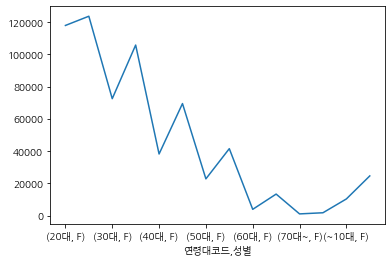

In [99]:
import matplotlib.pyplot as plt
bike_genderage['이용건수'].plot()

#### 2. 인구데이터셋 만들기


#### 1) 유입인구 데이터
- 일별 데이터 전처리
- 월별로 파일 합치기 
- 표준 행정구역별 행정동코드 데이터에서 행정동코드 10자리에서 8자리로 줄임
- 행정구를 고려한 월별 유입인구 최종 데이터셋 만들기
- 최종 대여소별 유입인구데이터 확인(월별로 파일 1개씩 만들어짐) 

#### 2) 생활인구 데이터
- 월별 데이터를 전처리
- 따릉이 대여소 별 생활인구 데이터 최종 데이터 만들기
- 최종 대여소별 생활인구데이터 확인(월별로 파일 1개씩 만들어짐)

#### 1) 유입인구 데이터

- 일별데이터 전처리 : 사용자 정의함수 InnerSmall() 이용 : * 값을 0으로 수정, 기준일, 시간, 행정동코드로 groupby.sum()

In [89]:
#한달의 일별 데이터를 각각 전처리
#12달 데이터 한번에 돌리는 함수
def inner_small():
    #12달 한번에 처리
    for mon in range(1,13):
        for day in range(1,32):
            if mon < 10:
                #1일~9일
                if 1 <= day <= 9:
                    df = pd.read_csv('INNER_PEOPLE_2020'+'0'+ str(mon) +'0'+ str(day) +'.csv', encoding='cp949')
                #10~30일 또는 31일
                else:
                    if mon == 2 and day >= 30:
                        break
                    elif mon % 2 == 0 and mon <= 6 and day==31:
                        break
                    elif mon == 9 and day == 31:
                        break
                    else:
                        df = pd.read_csv('INNER_PEOPLE_2020'+'0'+ str(mon) + str(day) +'.csv', encoding='cp949')

            elif mon >= 10:
                #1일~9일
                if 1 <= day <= 9:
                    df = pd.read_csv('INNER_PEOPLE_2020' + str(mon) +'0'+ str(day) +'.csv', encoding='cp949')
                #30일
                else:
                    if mon == 11 and day == 31:
                        break
                    else:
                        df = pd.read_csv('INNER_PEOPLE_2020' + str(mon) + str(day) +'.csv', encoding='cp949')


            #*값 0으로 변환
            for i in range(5, 34):
                df.iloc[:,i] = df.iloc[:,i].replace('*', 0)
                df.iloc[:,i] = pd.to_numeric(df.iloc[:, i], errors='coerce')

            #columns명 영어로 되어있는 파일 수정
            if df.columns[0] =='stdr_de_id':
                df.rename(columns = {'stdr_de_id': '기준일ID','tmzon_pd_se':'시간대구분', 'adstrd_code_se':'행정동코드',
                                     'tot_lvpop_co':'총생활인구수','mlng_resdnc_code_se':'거주지 자치구 코드'}, inplace=True)
            #기준일, 시간, 행정동코드로 groupby.sum
            df1 = df.groupby(['기준일ID','시간대구분','행정동코드']).sum()
            df1.drop('거주지 자치구 코드', axis='columns',inplace=True)

            if mon < 10:
                if day < 10:
                    df1.to_csv('inner_2020'+'0'+ str(mon)+'0'+ str(day) + '.csv', encoding='cp949',index=None)
                else:
                    df1.to_csv('inner_2020'+'0'+ str(mon) + str(day) + '.csv', encoding='cp949',index=None)
            elif mon >= 10:
                if day < 10:
                    df1.to_csv('inner_2020'+ str(mon)+'0'+ str(day) + '.csv', encoding='cp949',index=None)
                else:
                    df1.to_csv('inner_2020'+ str(mon) + str(day) + '.csv', encoding='cp949',index=None)


In [90]:
inner_small()

- 월별로 파일 합치기 :  사용자 정의함수 concat_inner() 이용

In [94]:
def inner_concat():
    #12달 한번에 처리
    for mon in range(10,13):
        inner = pd.DataFrame()
        for day in range(1,32):
            if mon < 10:
                #1일~9일
                if 1 <= day <= 9:
                    df = pd.read_csv('inner_2020' +'0'+ str(mon) +'0'+ str(day) +'.csv', encoding='cp949')
                    inner = pd.concat([inner, df])
                #10~30일 또는 31일
                else:
                    if mon == 2 and day >= 30:
                        break
                    elif mon % 2 == 0 and mon <= 6 and day==31:
                        break
                    elif mon == 9 and day == 31:
                        break
                    else:
                        df = pd.read_csv('inner_2020'+'0'+ str(mon) + str(day) +'.csv', encoding='cp949')
                        inner = pd.concat([inner, df])

                inner.to_csv('inner2020' + '0' + str(mon) +'.csv', encoding='cp949', index=None)

            elif mon >= 10:
                #1일~9일
                if 1 <= day <= 9:
                    df = pd.read_csv('inner_2020'+ str(mon) +'0'+ str(day) +'.csv', encoding='cp949')
                    inner = pd.concat([inner, df])
                #30일
                else:
                    if mon == 11 and day == 31:
                        break
                    else:
                        df = pd.read_csv('inner_2020'+ str(mon) +str(day) +'.csv', encoding='cp949')
                        inner = pd.concat([inner, df])

                inner.to_csv('inner2020'+ str(mon) +'.csv', encoding='cp949',index =None)


In [95]:
inner_concat()

- 표준 행정구역별 행정동코드 데이터에서 행정동코드 10자리에서 8자리로 줄임 :
인구 데이터의 행정동코드가 8자리 이기때문

In [31]:
#행정구역 코드
city = pd.read_csv('행정구역표.csv', encoding = 'UTF-8')
city
city = city.drop(['동', '시도명'], axis=1)
#행정동코드 전처리 : 10자리를 8자리로 바꾸고 필요없는 열 처리 후 저장
for i in range(len(city.행정동코드)):
    city.iloc[i,0] = str(city.행정동코드[i])[0:8]
city.to_csv('new행정구역표.csv', encoding = 'UTF-8',index = None)

city = pd.read_csv('new행정구역표.csv', encoding = 'UTF-8')
city

,행정동코드,구
0,11000000,NaN
1,11110000,종로구
2,11110510,종로구
3,11110515,종로구
4,11110520,종로구
...,...,...
1107,11740106,강동구
1108,11740107,강동구
1109,11740108,강동구
1110,11740109,강동구


- 행정구를 고려한 월별 유입인구 최종 데이터셋 만들기 : 사용자 정의함수 merge_month(year,mon) 이용

In [32]:
def merge_month():
    #12달 한번에 처리
    for mon in range(1,13):
        #행정구역표 불러오기
        city = pd.read_csv('new행정구역표.csv', encoding = 'UTF-8')
        #월별 유입인구 데이터 불러오기
        if mon < 10:
            inner = pd.read_csv('inner2020'+'0'+ str(mon) + '.csv', encoding='cp949')
        elif mon >= 10:
            inner = pd.read_csv('inner2020'+ str(mon) + '.csv', encoding='cp949')

        #유입인구 데이터 정리
        inner = inner.iloc[:,0:4]
        inner = inner.rename(columns={'기준일ID':'대여일자','시간대구분':'시간', '총생활인구수':'총유입인구'}) 

        #merge    
        city_inner = pd.merge(inner, city, on='행정동코드', how='left')
        city_inner = city_inner.groupby(['대여일자', '시간', '구']).sum()
        #groupby 후 인덱스 초기화
        city_inner = city_inner.reset_index()

        #연,월,일 넣어주기
        city_inner = city_inner.astype({'대여일자' : str})
        #비어있는 열 생성
        city_inner['년'] = 5
        city_inner['월'] = 5
        city_inner['일'] = 5
        for i in range(len(city_inner.대여일자)):
            yy = city_inner.대여일자[i][0:4]
            mm = city_inner.대여일자[i][4:6]
            dd = city_inner.대여일자[i][6:8]

            city_inner.loc[i,['년']] = yy
            city_inner.loc[i,['월']] = mm
            city_inner.loc[i,['일']] = dd

        city_inner.drop(['행정동코드'], axis=1, inplace=True)
        if mon < 10:
            city_inner.to_csv('innerData2020'+'0'+str(mon)+'.csv', encoding='cp949',index = None) 
        elif mon >= 10:
            city_inner.to_csv('innerData2020'+str(mon)+'.csv', encoding='cp949', index = None)

- 구별 유입인구 데이터 확인

In [34]:
#pd.read_csv('innerData202001.csv', encoding = 'cp949') #pd.read_csv('innerData202002.csv', encoding = 'cp949')
#pd.read_csv('innerData202003.csv', encoding = 'cp949') #pd.read_csv('innerData202004.csv', encoding = 'cp949')
pd.read_csv('innerData202002.csv', encoding = 'cp949')

,대여일자,시간,구,총유입인구,년,월,일
0,20200201,0,강남구,111685,2020,2,1
1,20200201,0,강동구,105914,2020,2,1
2,20200201,0,강북구,139153,2020,2,1
3,20200201,0,강서구,93695,2020,2,1
4,20200201,0,관악구,98757,2020,2,1
...,...,...,...,...,...,...,...
17395,20200229,23,용산구,53098,2020,2,29
17396,20200229,23,은평구,86138,2020,2,29
17397,20200229,23,종로구,50833,2020,2,29
17398,20200229,23,중구,37094,2020,2,29


- 따릉이 대여소 별 유입인구 최종 데이터 만들기 : 따릉이 대여소의 구별 데이터와 구별 최종 유입인구 데이터를 merge

In [ ]:
def bikename_inner_merge():
    bikename = pd.read_csv('공공자전거 대여소 정보_21.06.csv',encoding='cp949')
    #12달 한번에 처리
    for mon in range(1,13):
        if mon < 10:
            innerData = pd.read_csv('innerData2020'+'0'+str(mon)+'.csv',encoding='cp949')
        else:
            innerData = pd.read_csv('innerData2020' + str(mon)+'.csv',encoding='cp949')

        bikename_inner = pd.merge(bikename,innerData, on='구',how='left')

        if mon < 10:
            bikename_inner.to_csv('bike_inner2020'+'0'+str(mon)+'.csv',encoding ='cp949',index= None)
        else:
            bikename_inner.to_csv('bike_inner2020'+ str(mon)+'.csv',encoding ='cp949',index= None)

In [ ]:
bikename_inner_merge()

- 최종 대여소별 유입인구데이터 확인

In [57]:
pd.read_csv('bike_inner202002.csv', encoding = 'cp949')

,보관소명,구,대여일자,시간,총유입인구,년,월,일
0,망원역 1번출구 앞,마포구,20200201,0,100035,2020,2,1
1,망원역 1번출구 앞,마포구,20200201,1,95555,2020,2,1
2,망원역 1번출구 앞,마포구,20200201,2,92148,2020,2,1
3,망원역 1번출구 앞,마포구,20200201,3,90190,2020,2,1
4,망원역 1번출구 앞,마포구,20200201,4,89848,2020,2,1
...,...,...,...,...,...,...,...,...
1717027,잠실나들목6,송파구,20200229,19,219433,2020,2,29
1717028,잠실나들목6,송파구,20200229,20,211275,2020,2,29
1717029,잠실나들목6,송파구,20200229,21,199784,2020,2,29
1717030,잠실나들목6,송파구,20200229,22,187442,2020,2,29


#### 2) 생활인구

- 월별 데이터를 전처리 : 년월일시간 열을 생성한 데이터셋 만듬 

In [2]:
def LifeNum(mon):
    if mon < 10:
        life = pd.read_csv('LOCAL_PEOPLE_DONG_2020'+'0' + str(mon)+'.csv',index_col=False)
    else:
        life = pd.read_csv('LOCAL_PEOPLE_DONG_2020'+ str(mon)+'.csv',index_col=False)
        
    life_s = life.iloc[:, [0,1,2,3]]
    city = pd.read_csv('new행정구역표.csv')

    city_life = pd.merge(life_s, city, on='행정동코드', how='left')
    city_life.drop(['행정동코드'], axis=1, inplace=True)
    city_life = city_life.groupby(['기준일ID', '시간대구분', '구']).sum()
    #groupby 후 인덱스 초기화
    city_life = city_life.reset_index()

    #년월일 열 만들기
    city_life = city_life.astype({'기준일ID' : str})

    city_life['년'] = 5
    city_life['월'] = 5
    city_life['일'] = 5
    
    for i in range(len(city_life.기준일ID)):
        yy = city_life.기준일ID[i][0:4]
        mm = city_life.기준일ID[i][4:6]
        dd = city_life.기준일ID[i][6:8]
        
        city_life.loc[i,['년']] = yy
        city_life.loc[i,['월']] = mm
        city_life.loc[i,['일']] = dd
        
    city_life.rename(columns={'기준일ID':'대여일자','시간대구분':'시간'}, inplace=True)
    if mon < 10:
        city_life.to_csv('lifeData2020'+'0'+str(mon)+'.csv', encoding='cp949', index=None)
    else:
        city_life.to_csv('lifeData2020'+ str(mon)+'.csv', encoding='cp949', index=None)
    

- LifeNum(1) 부터 LifeNum(12)까지 가능

In [ ]:
for i in range(1, 13):
    LifeNum(i)

- 따릉이 대여소 별 생활인구 최종 데이터 만들기 : 따릉이 대여소의 구별 데이터와 구별 최종 생활인구 데이터를 merge

In [ ]:
def bikename_life_merge():
    #12달 한번에 처리
    for mon in range(1,13):
        bikename = pd.read_csv('공공자전거 대여소 정보_21.06.csv',encoding='cp949')
        if mon < 10:
            lifeData202001 = pd.read_csv('lifeData2020'+'0'+str(mon)+'.csv',encoding='cp949')
        else:
            lifeData202001 = pd.read_csv('lifeData2020'+str(mon)+'.csv',encoding='cp949')

        bikename_life = pd.merge(bikename,lifeData, on='구',how='left')

        if mon < 10:
            bikename_life.to_csv('bike_life2020'+'0'+str(mon)+'.csv',encoding ='cp949',index= None)
        else:
            bikename_life.to_csv('bike_life2020'+ str(mon)+'.csv',encoding ='cp949',index= None)

In [ ]:
bikename_life_merge()

- 최종 대여소별 생활인구데이터 확인

In [60]:
pd.read_csv('bike_life202010.csv', encoding = 'cp949') 

,보관소명,구,대여일자,시간,총생활인구수,년,월,일
0,망원역 1번출구 앞,마포구,20201001,0,376999.3951,2020,10,1
1,망원역 1번출구 앞,마포구,20201001,1,375698.2278,2020,10,1
2,망원역 1번출구 앞,마포구,20201001,2,373914.1877,2020,10,1
3,망원역 1번출구 앞,마포구,20201001,3,372507.4651,2020,10,1
4,망원역 1번출구 앞,마포구,20201001,4,371190.4680,2020,10,1
...,...,...,...,...,...,...,...,...
1835443,잠실나들목6,송파구,20201031,19,742289.9013,2020,10,31
1835444,잠실나들목6,송파구,20201031,20,735480.8655,2020,10,31
1835445,잠실나들목6,송파구,20201031,21,724076.1958,2020,10,31
1835446,잠실나들목6,송파구,20201031,22,719150.7821,2020,10,31


- 전처리된 대여, 반납 데이터에 유입, 생활인구 데이터를 추가: 전처리된 대여, 반납 데이터와 최종 유입, 생활인구 데이터를 merge

(전처리된 대여, 반납 데이터는 미세먼지 요소까지 합쳐진 데이터)

In [63]:
def bike_people():
    for mon in range(1,13):
        if mon < 10:
            bike_inner= pd.read_csv('bike_inner2020'+'0'+str(mon)+'.csv',encoding ='cp949')
            bike_life= pd.read_csv('bike_life2020'+'0'+str(mon)+'.csv',encoding ='cp949')
            rent = pd.read_csv('rent_dust_2020'+'0'+str(mon)+'.csv', encoding='cp949')
            return_ = pd.read_csv('return_dust_2020'+'0'+str(mon)+'.csv', encoding='cp949')
        else:
            bike_inner= pd.read_csv('bike_inner2020'+str(mon)+'.csv',encoding ='cp949')
            bike_life= pd.read_csv('bike_life2020'+ str(mon)+'.csv',encoding ='cp949')
            rent = pd.read_csv('rent_dust_2020'+str(mon)+'.csv', encoding='cp949')
            return_ = pd.read_csv('return_dust_2020'+str(mon)+'.csv', encoding='cp949')
            
        bike_inner = bike_inner.groupby(['보관소명','구','대여일자','시간','년','월','일'],as_index=False).sum()
        bike_life= bike_life.groupby(['보관소명','구','대여일자','시간','년','월','일'],as_index=False).sum()
        
        #대여데이터와 merge하기
        rent_inner = pd.merge(rent,bike_inner,on=['보관소명','년','월','일','시간'],how='left')
        rent_inner = rent_inner.drop(['구','대여일자'],axis = 1)
        rent_life = pd.merge(rent_inner,bike_life,on=['보관소명','년','월','일','시간'],how='left')
        rent_life = rent_life.drop(['구','대여일자'],axis = 1)
        rent_life = rent_life.groupby(['보관소명','년','월','일','요일','시간','대여량','기온','강수','미세먼지(㎍/㎥)','초미세먼지(㎍/㎥)'],as_index=False).sum()
        
        #대여데이터와 merge하기
        return_inner = pd.merge(return_,bike_inner,on=['보관소명','년','월','일','시간'],how='left')
        return_inner = return_inner.drop(['구','대여일자'],axis = 1)
        return_life = pd.merge(return_inner,bike_life,on=['보관소명','년','월','일','시간'],how='left')
        return_life = return_life.drop(['구','대여일자'],axis = 1)
        return_life = return_life.groupby(['보관소명','년','월','일','요일','시간','반납량','기온','강수','미세먼지(㎍/㎥)','초미세먼지(㎍/㎥)'],as_index=False).sum()
        
        if mon < 10:
            rent_life.to_csv('rent_life_2020'+'0'+str(mon)+'.csv',encoding='cp949',index =None)
            return_life.to_csv('return_life_2020'+'0'+str(mon)+'.csv',encoding='cp949',index =None)
        else:
            rent_life.to_csv('rent_life_2020'+str(mon)+'.csv',encoding='cp949',index =None)
            return_life.to_csv('return_life_2020'+str(mon)+'.csv',encoding='cp949',index =None)

In [64]:
bike_people()

In [65]:
pd.read_csv('rent_life_202001.csv',encoding='cp949')

,보관소명,년,월,일,요일,시간,대여량,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),총유입인구,총생활인구수
0,(구)신한은행 중랑교지점,2020,1,1,수,0,0,-2.2,0.1,31.0,16.0,76727.0,384600.6820
1,(구)신한은행 중랑교지점,2020,1,1,수,1,0,-2.2,0.1,31.0,16.0,74678.0,386599.3398
2,(구)신한은행 중랑교지점,2020,1,1,수,2,0,-2.2,0.1,31.0,16.0,73718.0,388041.4154
3,(구)신한은행 중랑교지점,2020,1,1,수,3,0,-2.2,0.1,31.0,16.0,73376.0,388881.0968
4,(구)신한은행 중랑교지점,2020,1,1,수,4,0,-2.2,0.1,31.0,16.0,73378.0,388602.5135
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107475,희성오피앙,2020,1,31,금,19,0,3.9,0.0,22.0,20.0,178115.0,534661.3875
1107476,희성오피앙,2020,1,31,금,20,2,3.9,0.0,22.0,20.0,176950.0,545656.0699
1107477,희성오피앙,2020,1,31,금,21,1,3.9,0.0,22.0,20.0,173326.0,554078.1238
1107478,희성오피앙,2020,1,31,금,22,1,3.9,0.0,22.0,20.0,163816.0,559261.3331


In [66]:
pd.read_csv('return_life_202001.csv',encoding='cp949')

,보관소명,년,월,일,요일,시간,반납량,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),총유입인구,총생활인구수
0,(구)신한은행 중랑교지점,2020,1,1,수,0,0,-2.2,0.1,31.0,16.0,76727.0,384600.6820
1,(구)신한은행 중랑교지점,2020,1,1,수,1,1,-2.2,0.1,31.0,16.0,74678.0,386599.3398
2,(구)신한은행 중랑교지점,2020,1,1,수,2,2,-2.2,0.1,31.0,16.0,73718.0,388041.4154
3,(구)신한은행 중랑교지점,2020,1,1,수,3,2,-2.2,0.1,31.0,16.0,73376.0,388881.0968
4,(구)신한은행 중랑교지점,2020,1,1,수,4,0,-2.2,0.1,31.0,16.0,73378.0,388602.5135
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107475,희성오피앙,2020,1,31,금,19,1,3.9,0.0,22.0,20.0,178115.0,534661.3875
1107476,희성오피앙,2020,1,31,금,20,1,3.9,0.0,22.0,20.0,176950.0,545656.0699
1107477,희성오피앙,2020,1,31,금,21,2,3.9,0.0,22.0,20.0,173326.0,554078.1238
1107478,희성오피앙,2020,1,31,금,22,1,3.9,0.0,22.0,20.0,163816.0,559261.3331


#### ▶ 요인 3 지하철 데이터 처리

- 대여소 - 지하철역 간의 거리 측정하기 위해 다른 분석 툴 사용

1. 승차 인원 데이터 : 반납량과 관련
- 승차를 하기 위해 지하철 주변 대여소에 반납하고 지하철에 승차하는 경우


2. 하차 인원 데이터 : 대여량과 관련
- 하차를 하고 나서 지하철 주변 대여소에서 대여하여 자전거를 이용하는 경우

In [1]:
import pandas as pd
import warnings
from tqdm import trange, notebook

#### 1. 데이터 적재 및 전처리

In [3]:
train = pd.read_csv('train_station2.csv', encoding='euc-kr')
train.head()

,지하철역명,호선번호,주소,시도코드(표준),시도명(표준),시군구코드(표준),시군구명(표준),행정읍면동코드(표준),행정읍면동명(표준),법정읍면동코드(표준),법정읍면동명(표준),국가기초구역코드(표준),Lat,Lng
0,서대문(5호선),5호선,서울특별시 종로구 평동 90,11,서울특별시,11110,종로구,1101058,교남동,11110177,평동,3181,37.565856,126.966637
1,경복궁(3호선),3호선,서울특별시 종로구 적선동 81-1,11,서울특별시,11110,종로구,1101053,사직동,11110107,적선동,3170,37.575861,126.973063
2,광화문(5호선),5호선,서울특별시 종로구 도렴동 83,11,서울특별시,11110,종로구,1101053,사직동,11110119,세종로,3172,37.571623,126.976788
3,종각(1호선),1호선,서울특별시 종로구 종로1가 20-3,11,서울특별시,11110,종로구,1101061,종로1·2·3·4가동,11110126,종로1가,3157,37.570214,126.983240
4,안국(3호선),3호선,서울특별시 종로구 안국동 148,11,서울특별시,11110,종로구,1101054,삼청동,11110141,안국동,3060,37.576720,126.985823


- 대여소의 위도 경도 데이터

In [4]:
bike = pd.read_csv('자전거_대여소_정보.csv', encoding='euc-kr')
bike.head()

,rackTotCnt,stationName,parkingBikeTotCnt,shared,stationLatitude,stationLongitude,stationId
0,22,망원역 1번출구 앞,12,55,37.555649,126.910629,ST-4
1,16,망원역 2번출구 앞,12,75,37.554951,126.910835,ST-5
2,15,합정역 1번출구 앞,0,0,37.550629,126.914986,ST-6
3,7,합정역 5번출구 앞,0,0,37.550007,126.914825,ST-7
4,12,합정역 7번출구 앞,5,42,37.548645,126.912827,ST-8


- distance : 자전거 대여소 별로 가장 가까운 지하철 역 간 거리가 300m이하인 대여소 데이터 

In [5]:
distance = pd.read_csv('distance.csv', encoding='euc-kr')
distance.columns = ['Bike_station_name', 'Train_station_name', 'Distance']
distance

,Bike_station_name,Train_station_name,Distance
0,ST-642,금천구청(경부선),197.511324
1,ST-925,청계산입구(신분당선),85.708775
2,ST-647,미아(4호선),93.295377
3,ST-407,청량리(1호선),252.033898
4,ST-1768,서울(경의선),197.500307
...,...,...,...
1130,ST-15,상수(6호선),99.640714
1131,ST-1238,남구로(7호선),77.738558
1132,ST-1805,종각(1호선),34.836553
1133,ST-751,구반포(9호선),149.468408


- distance 데이터 전처리

In [12]:
df = pd.read_csv('distance.csv', encoding='euc-kr')
df.columns = ['Bike_station_name', 'Train_station_name', 'Distance']
df

,Bike_station_name,Train_station_name,Distance
0,ST-642,금천구청(경부선),197.511324
1,ST-925,청계산입구(신분당선),85.708775
2,ST-647,미아(4호선),93.295377
3,ST-407,청량리(1호선),252.033898
4,ST-1768,서울(경의선),197.500307
...,...,...,...
1130,ST-15,상수(6호선),99.640714
1131,ST-1238,남구로(7호선),77.738558
1132,ST-1805,종각(1호선),34.836553
1133,ST-751,구반포(9호선),149.468408


In [7]:
distance = distance.groupby('Bike_station_name').min('Distance')

In [8]:
distance['Bike_station_name'] = distance.index
distance.reset_index(drop = True, inplace=True)
distance

,Distance,Bike_station_name
0,265.433308,ST-1000
1,53.940261,ST-1013
2,74.376768,ST-1015
3,7.897647,ST-1032
4,37.614214,ST-1034
...,...,...
878,39.931093,ST-976
879,276.486985,ST-977
880,64.949339,ST-983
881,24.723679,ST-985


In [10]:
distance = pd.merge(distance, df, how='left', on=['Bike_station_name', 'Distance'])

In [11]:
distance['호선'] = [name.split('(')[-1].split(')')[0] for name in distance.Train_station_name]
distance['역명'] = [name.split('(')[0] for name in distance.Train_station_name]
distance

,Distance,Bike_station_name,Train_station_name,호선,역명
0,265.433308,ST-1000,양천구청(2호선),2호선,양천구청
1,53.940261,ST-1013,등촌(9호선),9호선,등촌
2,74.376768,ST-1015,신목동(9호선),9호선,신목동
3,7.897647,ST-1032,독바위(6호선),6호선,독바위
4,37.614214,ST-1034,디지털미디어시티(6호선),6호선,디지털미디어시티
...,...,...,...,...,...
965,276.486985,ST-977,시청(2호선),2호선,시청
966,64.949339,ST-983,군자(7호선),7호선,군자
967,64.949339,ST-983,군자(5호선),5호선,군자
968,24.723679,ST-985,중곡(7호선),7호선,중곡


- 역별 일별 시간대 데이터셋 만들기

In [13]:
bike_train_distance = pd.merge(bike, distance.iloc[:, [3, 4, 1]], how = 'left', left_on= 'stationId', right_on='Bike_station_name').iloc[:, :-1]
bike_train_distance = bike_train_distance.iloc[:, [1, 6, 8, 7]]
bike_train_distance.head()

,stationName,stationId,역명,호선
0,망원역 1번출구 앞,ST-4,망원,6호선
1,망원역 2번출구 앞,ST-5,망원,6호선
2,합정역 1번출구 앞,ST-6,합정,2호선
3,합정역 5번출구 앞,ST-7,합정,2호선
4,합정역 7번출구 앞,ST-8,합정,6호선


- 1호선 - 8호선 일별 시간대별 승하차 인원 정보

In [14]:
train_using = pd.read_csv('서울교통공사 2020년 일별 시간대별 역별 승하차 인원(1_8호선).csv', encoding = 'euc-kr')
train_using.역명 = [name.split('(')[0] for name in train_using.역명]
train_using.head()

,날짜,호선,역번호,역명,구분,06:00 이전,06:00 ~ 07:00,07:00 ~ 08:00,08:00 ~ 09:00,09:00 ~ 10:00,...,15:00 ~ 16:00,16:00 ~ 17:00,17:00 ~ 18:00,18:00 ~ 19:00,19:00 ~ 20:00,20:00 ~ 21:00,21:00 ~ 22:00,22:00 ~ 23:00,23:00 ~ 24:00,24:00 이후
0,2020-01-01,1호선,150,서울역,승차,356,280,313,774,923,...,2972,3194,3342,3002,2857,2311,2523,1830,987,25
1,2020-01-01,1호선,150,서울역,하차,235,952,828,1043,1694,...,2286,2354,2261,1922,1696,1620,1181,768,426,77
2,2020-01-01,1호선,151,시청,승차,105,118,123,206,318,...,873,1019,1234,1383,1271,1061,991,572,217,2
3,2020-01-01,1호선,151,시청,하차,81,223,334,570,611,...,885,783,849,602,435,293,273,174,149,26
4,2020-01-01,1호선,152,종각,승차,798,366,198,236,310,...,1636,1748,1890,1879,1827,1955,1800,1259,406,6


In [15]:
지하철_승차 = train_using[train_using.구분 == '승차'].drop(['구분', '역번호'], axis = 1)
지하철_하차 = train_using[train_using.구분 == '하차'].drop(['구분', '역번호'], axis = 1)
지하철_승차 = 지하철_승차.reset_index().drop('index', axis = 1)
지하철_하차 = 지하철_하차.reset_index().drop('index', axis = 1)

- 년월일 데이터 프레임 만들기

In [16]:
col_sep = [23,24,25,2,1,22,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
def split_date(df) :
    year_list = []
    month_list = []
    day_list = []
    df = df.reset_index().drop('index', axis = 1)
    for date in df.날짜 :
        year = date.split('-')[0]
        month = date.split('-')[1]
        day = date.split('-')[2]
        year_list.append(year)
        month_list.append(month)
        day_list.append(day)

    df = pd.concat([df, pd.DataFrame({'년' : year_list, '월' : month_list, '일' : day_list})], axis = 1).iloc[:, col_sep]
    col_idx = ['년', '월' ,'일', '역명' ,'호선', 0, 5]
    col_idx = col_idx + [int(name.split(':')[0].replace('0', '')) for name in df.columns[6:10]] + [int(name.split(':')[0]) for name in df.columns[10:24]]
    df.columns = col_idx
    return df

In [17]:
지하철_승차 = split_date(지하철_승차)
지하철_하차 = split_date(지하철_하차)

In [18]:
승차_time = 지하철_승차.iloc[:, 5:].T.sort_index()
하차_time = 지하철_하차.iloc[:, 5:].T.sort_index()
승차_time['시간'] = 승차_time.index
하차_time['시간'] = 하차_time.index

- 지하철 역별로 년월일 데이터 프레임을 만든 후에 데이터를 각각 행 합치기 : 사용자 정의함수 MakeConcatData(train, time, start, end)

In [19]:
def MakeConcatData(train, time, start, end) :
    df = time.iloc[:, [start, 101140]]
    df.columns = ['지하철 승차 인원', '시간']
    df['년'] = train.iloc[0, 0]
    df['월'] = train.iloc[0, 1]
    df['일'] = train.iloc[0, 2]
    df['역명'] = train.iloc[0, 3]
    df['호선'] = train.iloc[0, 4]
    
    for i in range(start + 1, end) :
        df2 = time.iloc[:, [i, 101140]]
        df2.columns = ['지하철 승차 인원', '시간']
        df2['년'] = train.iloc[i, 0]
        df2['월'] = train.iloc[i, 1]
        df2['일'] = train.iloc[i, 2]
        df2['역명'] = train.iloc[i, 3]
        df2['호선'] = train.iloc[i, 4]
        df = pd.concat([df, df2])
    
    return df
    
def MakeFinalTrainData(train, time) :
    lst = []
    num = list(range(0, len(time.columns), 5057))
    
    for k in notebook.tqdm(range(1, len(num))) :
        globals()['df_{}'.format(k)] = MakeConcatData(train, time, num[k-1], num[k])
        lst.append(globals()['df_{}'.format(k)])
    final = pd.concat(lst)
    return final

In [ ]:
warnings.filterwarnings(action='ignore')
승차인원 = MakeFinalTrainData(지하철_승차, 승차_time)
승차인원 = pd.merge(bike_train_distance, 승차인원, how = 'left', on = ['역명', '호선'])
승차인원 = 승차인원.fillna({'시간' : 99, '년' : 0, '월' : 0, '일' : 0, '지하철 승차 인원' : 0}).astype({'지하철 승차 인원' : int, '시간' : int, '년' : int, '월' : int, '일' : int})

In [ ]:
warnings.filterwarnings(action='ignore')
하차인원 = MakeFinalTrainData(지하철_하차, 하차_time)
하차인원 = pd.merge(bike_train_distance, 하차인원, how = 'left', on = ['역명', '호선'])
하차인원 = 하차인원.fillna({'시간' : 99, '년' : 0, '월' : 0, '일' : 0, '지하철 하차 인원' : 0}).astype({'지하철 하차 인원' : int, '시간' : int, '년' : int, '월' : int, '일' : int})

- 완성된 데이터

In [21]:
pd.read_csv('지하철_승차최종.csv', encoding='cp949')

,년,월,일,시간,보관소명,보관소ID,역명,지하철_승차인원
0,0,0,0,99,(재)FITI시험연구원,ST-2041,양천향교,0
1,0,0,0,99,19민주묘지 입구사거리,ST-2136,4.19.민주묘지,0
2,0,0,0,99,19민주묘지역,ST-1389,4.19.민주묘지,0
3,0,0,0,99,19민주묘지역 1번출구,ST-2133,4.19.민주묘지,0
4,0,0,0,99,9호선종합운동장역 9번출구,ST-540,종합운동장,0
...,...,...,...,...,...,...,...,...
4714347,2020,12,31,23,회현역 7번출구,ST-1776,회현,36
4714348,2020,12,31,23,효성인텔리안 앞,ST-1109,수유,86
4714349,2020,12,31,23,효창공원앞역 3번출구 뒤,ST-1341,효창공원앞,20
4714350,2020,12,31,23,효창공원앞역 5번출구 옆,ST-2455,효창공원앞,20


In [22]:
pd.read_csv('지하철_하차최종.csv', encoding='cp949')

,년,월,일,시간,보관소명,보관소ID,역명,지하철_하차인원
0,0,0,0,99,(재)FITI시험연구원,ST-2041,양천향교,0
1,0,0,0,99,19민주묘지 입구사거리,ST-2136,4.19.민주묘지,0
2,0,0,0,99,19민주묘지역,ST-1389,4.19.민주묘지,0
3,0,0,0,99,19민주묘지역 1번출구,ST-2133,4.19.민주묘지,0
4,0,0,0,99,9호선종합운동장역 9번출구,ST-540,종합운동장,0
...,...,...,...,...,...,...,...,...
4714347,2020,12,31,23,회현역 7번출구,ST-1776,회현,25
4714348,2020,12,31,23,효성인텔리안 앞,ST-1109,수유,430
4714349,2020,12,31,23,효창공원앞역 3번출구 뒤,ST-1341,효창공원앞,34
4714350,2020,12,31,23,효창공원앞역 5번출구 옆,ST-2455,효창공원앞,34


- 지하철 승하차 인구 데이터를 합

In [6]:
def sub_people():
    rent_sub = pd.read_csv('지하철_하차최종.csv', encoding='cp949')
    return_sub = pd.read_csv('지하철_승차최종.csv',encoding='cp949')
    for mon in range(1,13):
        if mon < 10:
            rent = pd.read_csv('rent_life_2020'+'0'+str(mon)+'.csv', encoding='cp949')
            return_ = pd.read_csv('return_life_2020'+'0'+str(mon)+'.csv', encoding='cp949')
        else:
            rent = pd.read_csv('rent_life_2020'+str(mon)+'.csv', encoding='cp949')
            return_ = pd.read_csv('return_life_2020'+str(mon)+'.csv', encoding='cp949')
            
        rent_subsub = pd.merge(rent,rent_sub,on =['보관소명','년','월','일','시간'], how='left')
        rent_subsub = rent_subsub.fillna(0)
        rent_subsub = rent_subsub.dropna()
        rent_subsub = rent_subsub.drop(['보관소ID','역명'],axis=1)
        
        return_subsub = pd.merge(return_,return_sub,on =['보관소명','년','월','일','시간','보관소명'], how='left')
        return_subsub = return_subsub.fillna(0)
        return_subsub = return_subsub.dropna()
        return_subsub = return_subsub.drop(['보관소ID','역명'],axis=1)
        
        if mon < 10:
            rent_subsub.to_csv('rent_last_2020'+'0'+str(mon)+'.csv',encoding='cp949',index =None)
            return_subsub.to_csv('return_last_2020'+'0'+str(mon)+'.csv',encoding='cp949',index =None)
        else:
            rent_subsub.to_csv('rent_last_2020'+str(mon)+'.csv',encoding='cp949',index =None)
            return_subsub.to_csv('return_last_2020'+str(mon)+'.csv',encoding='cp949',index =None)

In [7]:
sub_people()

In [8]:
pd.read_csv('rent_last_202001.csv', encoding='cp949')

,보관소명,년,월,일,요일,시간,대여량,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),총유입인구,총생활인구수,지하철_하차인원
0,(구)신한은행 중랑교지점,2020,1,1,수,0,0,-2.2,0.1,31.0,16.0,76727.0,384600.6820,0.0
1,(구)신한은행 중랑교지점,2020,1,1,수,1,0,-2.2,0.1,31.0,16.0,74678.0,386599.3398,0.0
2,(구)신한은행 중랑교지점,2020,1,1,수,2,0,-2.2,0.1,31.0,16.0,73718.0,388041.4154,0.0
3,(구)신한은행 중랑교지점,2020,1,1,수,3,0,-2.2,0.1,31.0,16.0,73376.0,388881.0968,0.0
4,(구)신한은행 중랑교지점,2020,1,1,수,4,0,-2.2,0.1,31.0,16.0,73378.0,388602.5135,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107475,희성오피앙,2020,1,31,금,19,0,3.9,0.0,22.0,20.0,178115.0,534661.3875,1937.0
1107476,희성오피앙,2020,1,31,금,20,2,3.9,0.0,22.0,20.0,176950.0,545656.0699,1189.0
1107477,희성오피앙,2020,1,31,금,21,1,3.9,0.0,22.0,20.0,173326.0,554078.1238,740.0
1107478,희성오피앙,2020,1,31,금,22,1,3.9,0.0,22.0,20.0,163816.0,559261.3331,877.0


In [9]:
pd.read_csv('return_last_202001.csv', encoding='cp949')

,보관소명,년,월,일,요일,시간,반납량,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),총유입인구,총생활인구수,지하철_승차인원
0,(구)신한은행 중랑교지점,2020,1,1,수,0,0,-2.2,0.1,31.0,16.0,76727.0,384600.6820,0.0
1,(구)신한은행 중랑교지점,2020,1,1,수,1,1,-2.2,0.1,31.0,16.0,74678.0,386599.3398,0.0
2,(구)신한은행 중랑교지점,2020,1,1,수,2,2,-2.2,0.1,31.0,16.0,73718.0,388041.4154,0.0
3,(구)신한은행 중랑교지점,2020,1,1,수,3,2,-2.2,0.1,31.0,16.0,73376.0,388881.0968,0.0
4,(구)신한은행 중랑교지점,2020,1,1,수,4,0,-2.2,0.1,31.0,16.0,73378.0,388602.5135,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107475,희성오피앙,2020,1,31,금,19,1,3.9,0.0,22.0,20.0,178115.0,534661.3875,503.0
1107476,희성오피앙,2020,1,31,금,20,1,3.9,0.0,22.0,20.0,176950.0,545656.0699,343.0
1107477,희성오피앙,2020,1,31,금,21,2,3.9,0.0,22.0,20.0,173326.0,554078.1238,306.0
1107478,희성오피앙,2020,1,31,금,22,1,3.9,0.0,22.0,20.0,163816.0,559261.3331,209.0


◈ 뚝섬유원지역 1번출구 앞 - 자전거 부족현상 예시

Text(0, 0.5, '자전거 부족 여부')

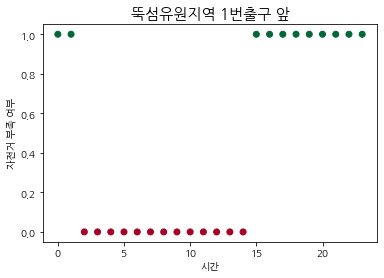

In [69]:
#502
predict_rent = pd.read_csv("뚝섬예측값.csv",encoding = 'cp949')
predict_return = pd.read_csv("뚝섬반납값.csv",encoding = 'cp949')

predict = pd.merge(predict_rent,predict_return, on ='time',how='left')
predict.columns= ['time','대여량','대여예측량','반납량','반납예측량']
predict_0825 = predict.iloc[1256:1296,:]

c = predict_0825['time']
d = []
e = []
month = []
day = []
time = []

for i in c:
    d.append(i.split(' ')[0])
for i in c:
    e.append(i.split(' ')[-1])


for i in d:
    month.append(i.split('-')[1])

for i in d:
    day.append(i.split('-')[2])

for i in e:
    time.append(i.split(":")[0])

predict_0825.insert(4, '월', month)
predict_0825.insert(5, '일', day)
predict_0825.insert(6, '시간', time)

predict_0825 = predict_0825.drop('time',axis =1)
pre_0825 = predict_0825.astype(int)
#pre_0825 = pre_0825[['월','일','시간','대여예측량','반납예측량','대여량','반납량']]
pre_0825 = pre_0825[['월','일','시간','대여예측량','반납예측량']]
pre_0825.columns= ['월','일','시간','F','R']
pre_0825['β'] = 23
for i in range(1,40):
    pre_0825.iloc[i,5] = pre_0825.iloc[i-1,5] + pre_0825.iloc[i-1,4] - pre_0825.iloc[i-1,3]
    if pre_0825.iloc[i,5] < 0 :
        pre_0825.iloc[i,5] = 0

pre_0825['α'] = 'True'
pre_0825['a'] = 1
for i in range(0,40):
    if pre_0825.iloc[i,5] < pre_0825.iloc[i,3]:
        pre_0825.iloc[i,6] = 'True'
        pre_0825.iloc[i,7] = 1        
    else:
        pre_0825.iloc[i,6] = 'False'
        pre_0825.iloc[i,7] = 0
    
pre_0825 = pre_0825.iloc[16:40,:]
pre_0825

plt.scatter(pre_0825.시간,pre_0825.a, c = pre_0825.a ,cmap='RdYlGn')

plt.title('뚝섬유원지역 1번출구 앞',fontsize=15)
plt.xlabel('시간')
plt.ylabel('자전거 부족 여부')